In [2]:
import os
import time
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [3]:
from sklearn.cluster import SpectralClustering

In [4]:
import visual_behavior_glm.GLM_analysis_tools as gat

In [5]:
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

from visual_behavior.dimensionality_reduction import clustering as vba_clust

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


### get experiments and cells tables and limit to closest familiar and novel active

In [7]:
experiments_table = loading.get_platform_paper_experiment_table()
len(experiments_table)

1249

In [8]:
# limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)
len(experiments_table)

402

In [9]:
matched_experiments = experiments_table.index.values

In [10]:
cells_table = loading.get_cell_table()
len(cells_table.cell_specimen_id.unique())

28833

In [11]:
# limit to cells matched in closest familiar and novel active
cells_table = utilities.limit_to_last_familiar_second_novel_active(cells_table)
cells_table = utilities.limit_to_containers_with_all_experience_levels(cells_table)
cells_table = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(cells_table)
len(cells_table.cell_specimen_id.unique())

3921

In [12]:
matched_cells = cells_table.cell_specimen_id.unique()

In [13]:
cre_lines = np.sort(cells_table.cre_line.unique())

cell_types={}
for cre_line in cre_lines:
    cell_types[cre_line] = experiments_table[experiments_table.cre_line==cre_line].cell_type.unique()[0]

### get GLM output, filter and reshape

In [15]:
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [527]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    
folder = '220218'
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [17]:
results_pivoted = gat.build_pivoted_results_summary(value_to_use=model_output_type, results_summary=None,
                                             glm_version=glm_version, cutoff=None)

full_results_pivoted = results_pivoted.copy()

# get rid of passive sessions
results_pivoted = results_pivoted[results_pivoted.passive==False]

In [18]:
# limit to last familiar and second novel 
results_pivoted = results_pivoted[results_pivoted.ophys_experiment_id.isin(matched_experiments)]
results_pivoted = results_pivoted[results_pivoted.cell_specimen_id.isin(matched_cells)]
print(len(results_pivoted.cell_specimen_id.unique()))

results_pivoted.to_hdf(os.path.join(save_dir, glm_version+'_results_pivoted.h5'), key='df')

3921


In [19]:
level_up_features = ['all-images', 'omissions', 'behavioral', 'task']
columns = [*level_up_features, 'cell_specimen_id', 'experience_level']
features = level_up_features 

results_pivoted = results_pivoted.sort_values('date_of_acquisition').reset_index(drop=True)
rspm = results_pivoted[columns]

# make everything positive
for feature in features: 
    rspm[feature] = np.abs(rspm[feature]) 
    
df = vba_clust.pivot_df(rspm, dropna=True)
print(len(df))

df.to_hdf(os.path.join(save_dir, glm_version+'_df.h5'), key='df')

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


No duplicated cells found
3921


In [181]:
# # add meta data to the dropout scores df
# df_new = df.reset_index()
# df_meta = df_new[['cell_specimen_id']].merge(cells_table[['cell_specimen_id', 'cre_line', 'cell_type',
#                                                           'targeted_structure', 'imaging_depth', 'binned_depth',
#                                                          'project_code', 'equipment_name', 'mouse_id']], 
#                                                         on = 'cell_specimen_id')
# df_meta = df_meta.drop_duplicates(subset='cell_specimen_id')
# df_meta = df_meta.set_index('cell_specimen_id')
# len(df_meta)

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


3921

In [190]:
# get metadata for cells in matched cells df
df_meta = cells_table[cells_table.cell_specimen_id.isin(df.index.values)]
df_meta = df_meta.drop_duplicates(subset='cell_specimen_id')
df_meta = df_meta.set_index('cell_specimen_id')
len(df_meta)

3921

### plot feature matrix for clustering

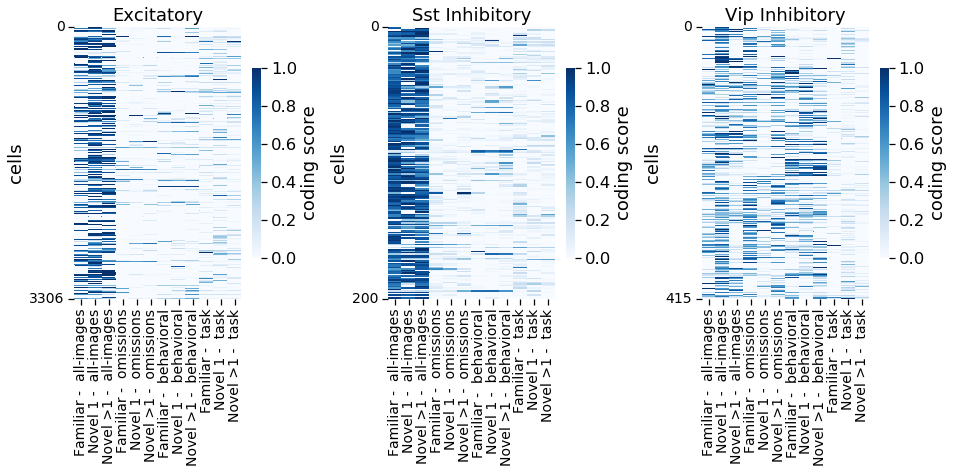

In [136]:
figsize = (15,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    cell_specimen_ids = df_meta[df_meta.cre_line==cre_line].cell_specimen_id.unique()
    data = df.loc[cell_specimen_ids]
    ax[i] = sns.heatmap(data.values, cmap='Blues', ax=ax[i], vmin=0, vmax=1,
                     robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'coding score'})

    ax[i].set_title(cell_types[cre_line])
    ax[i].set_ylabel('cells')
    ax[i].set_ylim(0, data.shape[0])
    ax[i].set_yticks([0, data.shape[0]]);
    ax[i].set_yticklabels((0, data.shape[0]), fontsize=14);
    ax[i].set_ylim(ax[i].get_ylim()[::-1]) #flip y axes so larger clusters are on top
    ax[i].set_xlabel('')
    ax[i].set_xlim(0, data.shape[1])
    ax[i].set_xticks(np.arange(0, data.shape[1])+0.5)
    ax[i].set_xticklabels([key[1]+' -  '+key[0] for key in list(data.keys())], rotation=90, fontsize=14);

fig.subplots_adjust(wspace=0.5)
utils.save_figure(fig, figsize, base_dir, folder, 'feature_matrix_unsorted')

### umap on feature matrix

In [196]:
import umap

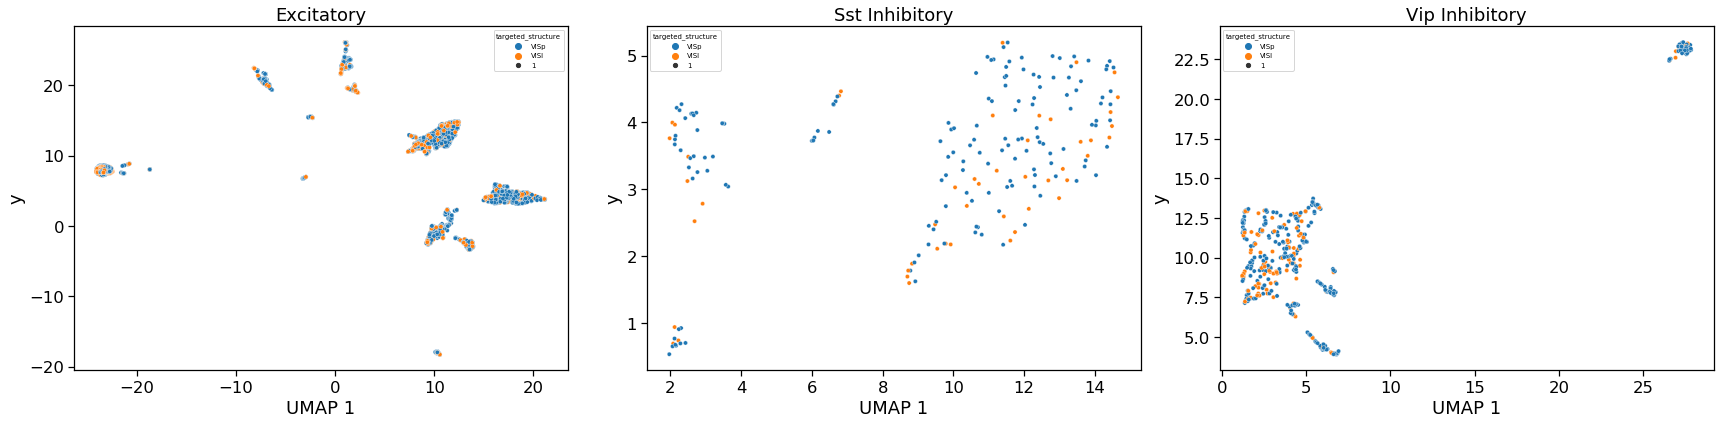

In [222]:
# for column in ['project_code', 'binned_depth', 'targeted_structure', 'mouse_id']:
column = 'targeted_structure'
n_cols = len(df_meta[column].unique())
palette = sns.color_palette()[:n_cols]

fig, ax = plt.subplots(1,3, figsize = (20,6))
for i, cre_line in enumerate(cre_lines):
    cell_specimen_ids = df_meta[df_meta.cre_line==cre_line].index.values
    X = df.loc[cell_specimen_ids]
    fit = umap.UMAP()
    u = fit.fit_transform(X)
    labels = [df_meta.loc[cell_specimen_id, column] for cell_specimen_id in cell_specimen_ids]
    umap_df = pd.DataFrame()
    umap_df['x'] = u[:, 0]
    umap_df['y'] = u[:, 1]
    umap_df['labels'] = labels
    ax[i] = sns.scatterplot(data=umap_df, x='x', y='y', hue='labels', size=1, ax=ax[i], palette=palette )
    ax[i].set_xlabel('UMAP 0')
    ax[i].set_xlabel('UMAP 1')
    ax[i].legend(fontsize='x-small', title=column, title_fontsize='x-small')
    ax[i].set_title(cell_types[cre_line])
fig.tight_layout()

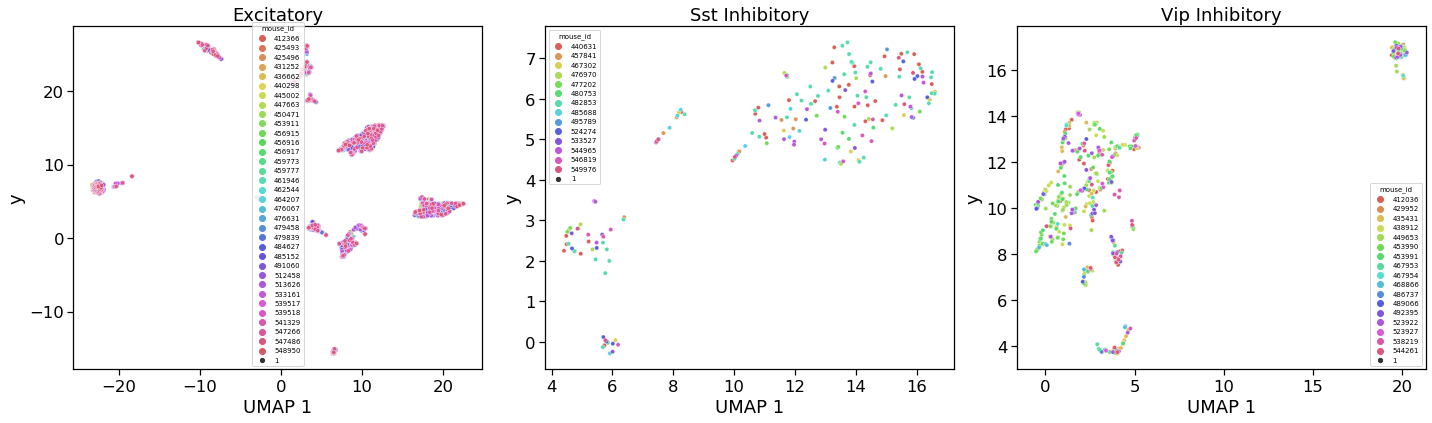

In [223]:
# for column in ['project_code', 'binned_depth', 'targeted_structure', 'mouse_id']:
column = 'mouse_id'

fig, ax = plt.subplots(1,3, figsize = (20,6))
for i, cre_line in enumerate(cre_lines):
    cre_meta = df_meta[df_meta.cre_line==cre_line]
    cell_specimen_ids = cre_meta.index.values
    n_cols = len(cre_meta[column].unique())
    palette = sns.color_palette('hls', n_cols)
    X = df.loc[cell_specimen_ids]
    fit = umap.UMAP()
    u = fit.fit_transform(X)
    labels = [df_meta.loc[cell_specimen_id, column] for cell_specimen_id in cell_specimen_ids]
    umap_df = pd.DataFrame()
    umap_df['x'] = u[:, 0]
    umap_df['y'] = u[:, 1]
    umap_df['labels'] = labels
    ax[i] = sns.scatterplot(data=umap_df, x='x', y='y', hue='labels', size=1, ax=ax[i], palette=palette )
    ax[i].set_xlabel('UMAP 0')
    ax[i].set_xlabel('UMAP 1')
    ax[i].legend(fontsize='x-small', title=column, title_fontsize='x-small')
    ax[i].set_title(cell_types[cre_line])
fig.tight_layout()

### Determine # clusters from Silhouette scores

In [23]:
cre_lines = np.sort(df_meta['cre_line'].unique())
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = df_meta[df_meta['cre_line']==cre_line]['cell_specimen_id']
    df_cre = df.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

In [24]:
cre_lines = np.sort(df_meta['cre_line'].unique())

<a id='1p1'></a>
### 1.1 Silhouette scores

In [25]:
n_clusters = np.arange(2,30)
sil_filename = glm_version+'_silhouette_scores.pkl'
sil_path = os.path.join(save_dir, sil_filename)
print(sil_path)
if os.path.exists(sil_path):
    print('loading file...')
    with open(sil_path, 'rb') as f:
        silhouette_scores_cre = pkl.load(f)
        f.close()    
    print('done.')
else:
    silhouette_scores_cre = {}
    for cre_line in cre_lines:
        tmp = cre_line_dfs[cre_line]
        X = tmp.values
        sc=SpectralClustering()
        silhouette_scores, silhouette_std = vba_clust.get_silhouette_scores(X, 
                                                                            model=sc, 
                                                                            n_clusters=n_clusters, 
                                                                            n_boots=40,
                                                                            metric='euclidean')
        silhouette_scores_cre[cre_line]= [silhouette_scores, silhouette_std]
    vba_clust.save_clustering_results(silhouette_scores_cre, filename_string=sil_filename, path=save_dir)

\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_events_all_L2_optimize_by_session\220218\24_events_all_L2_optimize_by_session_silhouette_scores.pkl
loading file...
done.


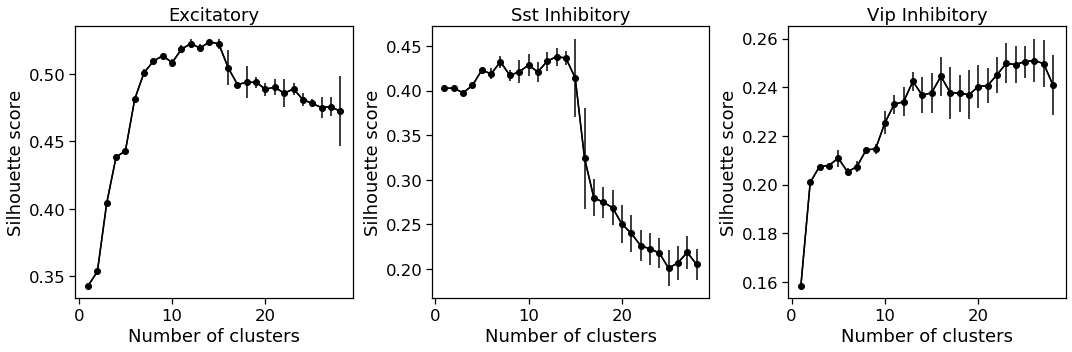

In [26]:
figsize = (15,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i,cre_line in enumerate(cre_lines):
    sil_scores = silhouette_scores_cre[cre_line]
    ax[i] = vba_clust.plot_silhouette_scores(silhouette_scores=sil_scores[0], 
                                             silhouette_std=sil_scores[1], ax=ax[i])
    ax[i].set_title(cell_types[cre_line])
plt.grid()
fig.savefig(fname=os.path.join(save_dir, 'sillhouette_scores.png'))
# utils.save_figure(fig, figsize, base_dir, folder, 'silhouette_scores')

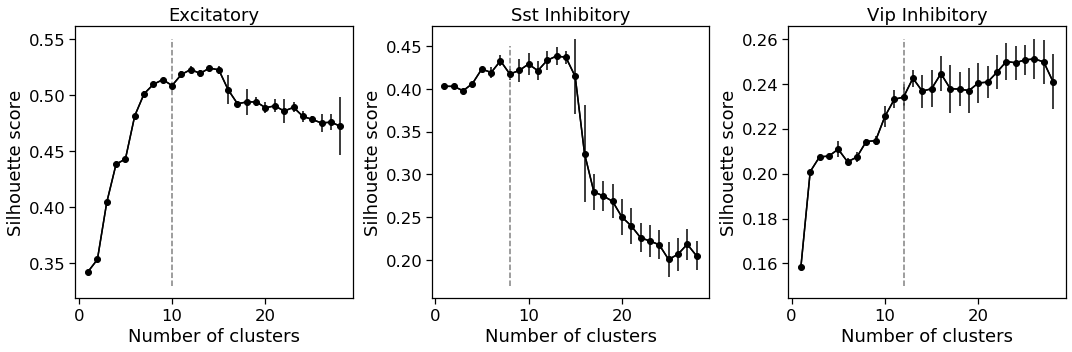

In [616]:
figsize = (15,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i,cre_line in enumerate(cre_lines):
    sil_scores = silhouette_scores_cre[cre_line]
    ax[i] = vba_clust.plot_silhouette_scores(silhouette_scores=sil_scores[0], 
                                             silhouette_std=sil_scores[1], ax=ax[i])
    ax[i].set_title(cell_types[cre_line])
    
ymin=0.1
ymax=0.6
ax[0].vlines(x=10, ymin=0.33, ymax=0.55, linestyle='--', color='gray')
ax[1].vlines(x=8, ymin=0.17, ymax=0.45, linestyle='--', color='gray')
ax[2].vlines(x=12, ymin=0.15, ymax=0.26, linestyle='--', color='gray')

plt.grid()
fig.savefig(fname=os.path.join(save_dir, 'sillhouette_scores.png'))
utils.save_figure(fig, figsize, base_dir, folder, 'silhouette_scores')

# select  number of clusters

In [28]:
n_clusters_cre = [10,8,12]

<a id='1p2'></a>
### 1.2 Coclustering matrix 

In [29]:
coclust_filename = glm_version+'_coClustering_matrix.pkl'
coclust_path = os.path.join(save_dir, coclust_filename)
if os.path.exists(coclust_path):
    print('loading file...')
    with open(coclust_path, 'rb') as f:
        coclustering_matrices  = pkl.load(f)
        f.close()
        print('done.')
else:
    coclustering_matrices = {}
    for i, cre_line in enumerate(cre_lines):
        sc = SpectralClustering()
        # could try k-means instead here
        X = cre_line_dfs[cre_line].values
        m = vba_clust.get_coClust_matrix(X=X, n_clusters=n_clusters_cre[i] ,model=sc, nboot=np.arange(100))
        coclustering_matrices[cre_line]=m
    vba_clust.save_clustering_results(coclustering_matrices, filename_string=coclust_filename, path=save_dir)

loading file...
done.


### plot co-clustering matrix sorted by dendrogram

 i combined info from several stackoverflow posts to figure out how to properly cut the dendrogram to match the number of clusters. i still havent figured out how to label the dendrogram with the cluster IDs, but i got close. at least i figured out what order the dendrogram was plotting the clusters in, and put that in the plot title, so i could label manually if i wanted to. 
 
 relevant links: 
 
 https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram
 
 https://stackoverflow.com/questions/11917779/how-to-plot-and-annotate-hierarchical-clustering-dendrograms-in-scipy-matplotlib
 
 https://stackoverflow.com/questions/12897374/get-unique-values-from-a-list-in-python
 
 https://stackoverflow.com/questions/35873273/display-cluster-labels-for-a-scipy-dendrogram
 
 https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/#h2_7

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

### plot dendrogram and co-clustering matrix for one cre line

n_original_observations: 200
n_labels: 200
n_leaves: 200
[1, 6, 9, 5, 10, 3, 4, 0, 2, 11, 8, 7]


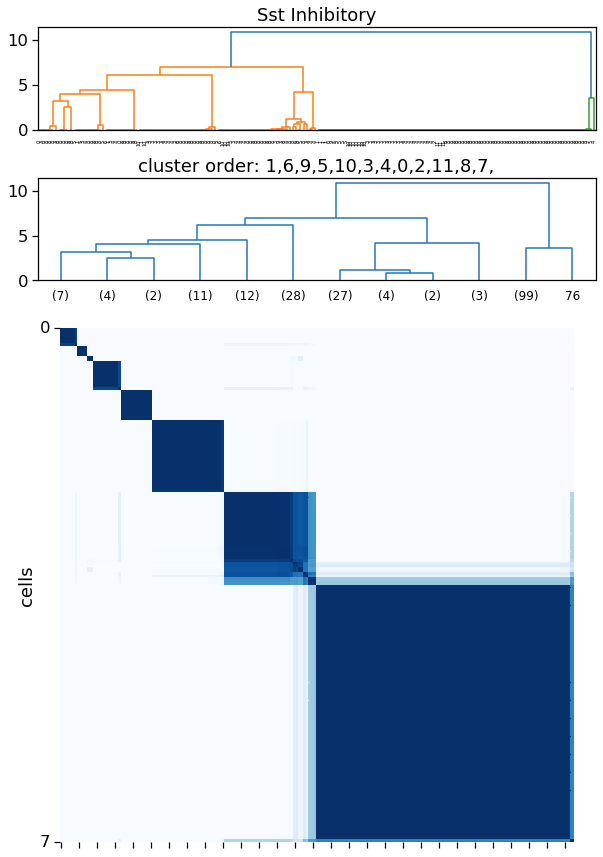

In [31]:
cluster_labels_cre = {}
cre_line = cre_lines[1]
# for i, cre_line in enumerate(cre_lines):
figsize = (10,15)
fig, ax = plt.subplots(3, 1, figsize=figsize, gridspec_kw={'height_ratios': [1, 1, 5]})
X = coclustering_matrices[cre_line]
n_original_observations = X[0].shape[0]
print('n_original_observations:', n_original_observations)
# peform aggloberative clustering to get cluster labels
cluster = AgglomerativeClustering(n_clusters=n_clusters_cre[i], affinity='euclidean', linkage='average')
cluster_labels = cluster.fit_predict(X)
cluster_labels_cre[cre_line] = cluster_labels
print('n_labels:', len(cluster_labels))
# get linkage matrix using same parameters as were used for clustering
Z = linkage(X, method='average', metric='euclidean')
# create dendrogram from linkage matrix and get dict R to get the leaves 
R = dendrogram(Z, no_plot=True,  count_sort='descending'); #truncate_mode='level', p=p)
# the leaves are the original matrix indices reordered according to dendrogram
leaves = R['leaves']
nodes = R['ivl']
print('n_leaves:', len(leaves))
# to get cluster labels for each leaf, reorder the labels from clustering by the leaf order
leaf_cluster_ids = cluster_labels[leaves] # labels=leaf_cluster_ids,
# get just the unique cluster IDs in the same order as they occur in the leaves
cluster_order = list(dict.fromkeys(leaf_cluster_ids))
# define a leaf label function for what to do when labeling non-singleton clusters
# def leaf_label_func(leaf):
#     return str(leaf_cluster_ids[leaf])
# create a label dictionary
# temp = {R["leaves"][ii]: leaf_cluster_ids[ii] for ii in range(len(R["leaves"]))}
def llf(xx):
    print(xx)
    return str(cluster_order[xx])
# now plot the same dendrogram with labels
dendrogram(Z, labels=leaf_cluster_ids, count_sort='descending', ax=ax[0]); #, leaf_label_function=llf, truncate_mode='level', p=p, 
ax[0].grid(False)
ax[0].set_title(cell_types[cre_line])

# plot dendrogram with leaves truncated to highest level nodes (p=n_clusters)
dendrogram(Z, truncate_mode='lastp', p=n_clusters_cre[i], color_threshold=0, count_sort='descending', ax=ax[1]); # leaf_label_func=llf,truncate_mode='level', p=p, 
title = 'cluster order: '
for c in cluster_order:
    title = title+str(c)+','
ax[1].set_title(title)
print(cluster_order)
ax[1].grid(False)

# Sort co-clustering matrix according to dendrogram output
sorted_order_int = []
for x in R['leaves']:
    sorted_order_int.append(int(x))

coClust_matrix_sorted = []                      
for row in X:
    coClust_matrix_sorted.append(row[sorted_order_int])
coClust_matrix_sorted = np.array(coClust_matrix_sorted)
coClust_matrix_sorted = coClust_matrix_sorted[sorted_order_int]
ax[2] = sns.heatmap(coClust_matrix_sorted, cmap="Blues", ax=ax[2], cbar=False, square=True)
ax[2].set_xticklabels('')
ax[2].set_yticks((0,coClust_matrix_sorted.shape[0]));
ax[2].set_ylabel('cells')
utils.save_figure(fig, figsize, base_dir, folder, 'dendrogram_coCluster_matrix_'+cre_line)

### all cre lines

n_original_observations: 3306
n_labels: 3306
n_leaves: 3306
[1, 5, 3, 4, 0, 9, 6, 7, 8, 2]
n_original_observations: 200
n_labels: 200
n_leaves: 200
[7, 3, 5, 2, 1, 4, 6, 0]
n_original_observations: 415
n_labels: 415
n_leaves: 415
[1, 5, 7, 10, 2, 6, 0, 8, 9, 4, 11, 3]


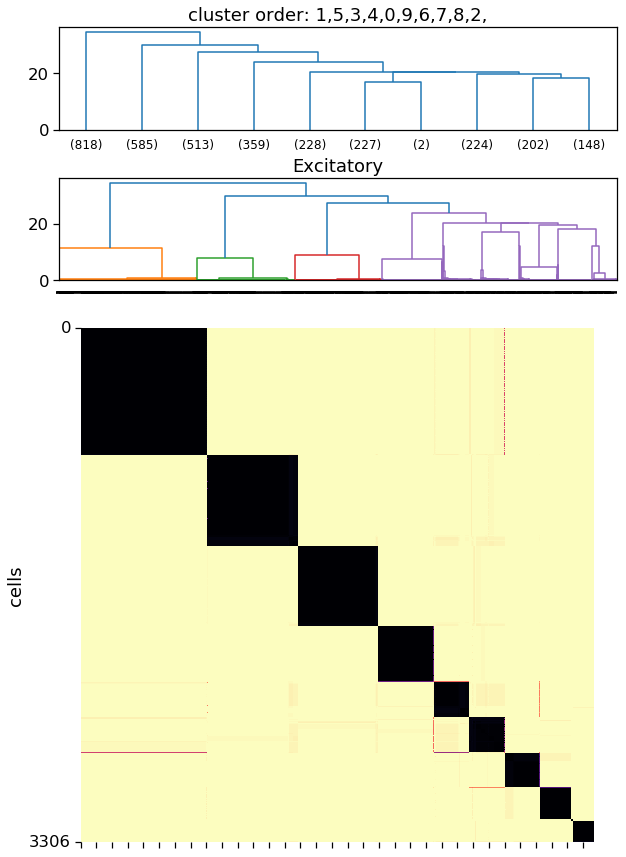

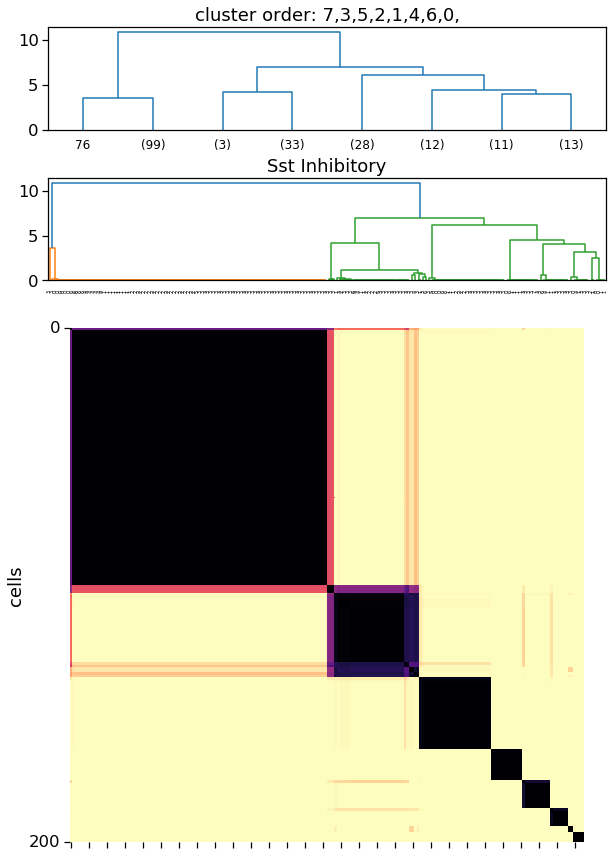

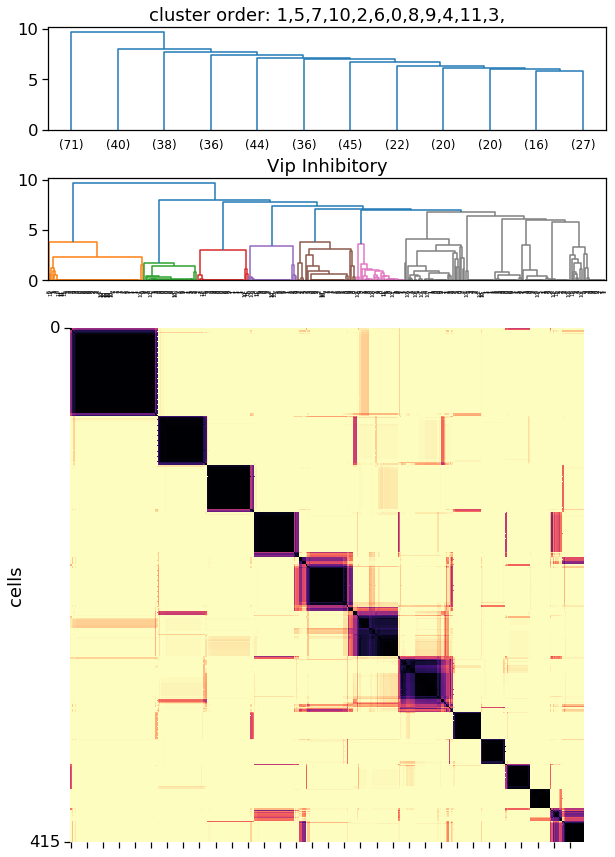

In [617]:
cluster_labels_cre = {}
for i, cre_line in enumerate(cre_lines):
    figsize = (10,15)
    fig, ax = plt.subplots(3, 1, figsize=figsize, gridspec_kw={'height_ratios': [1, 1, 5]})
    X = coclustering_matrices[cre_line]
    n_original_observations = X[0].shape[0]
    print('n_original_observations:', n_original_observations)
    # peform aggloberative clustering to get cluster labels
    cluster = AgglomerativeClustering(n_clusters=n_clusters_cre[i], affinity='euclidean', linkage='average')
    cluster_labels = cluster.fit_predict(X)
    cluster_labels_cre[cre_line] = cluster_labels
    print('n_labels:', len(cluster_labels))
    # get linkage matrix using same parameters as were used for clustering
    Z = linkage(X, method='average', metric='euclidean')
    # create dendrogram from linkage matrix and get dict R to get the leaves 
    R = dendrogram(Z, no_plot=True,  ); #truncate_mode='level', p=p)
    # the leaves are the original matrix indices reordered according to dendrogram
    leaves = R['leaves']
    nodes = R['ivl']
    print('n_leaves:', len(leaves))
    # to get cluster labels for each leaf, reorder the labels from clustering by the leaf order
    leaf_cluster_ids = cluster_labels[leaves] # labels=leaf_cluster_ids,
    # get just the unique cluster IDs in the same order as they occur in the leaves
    cluster_order = list(dict.fromkeys(leaf_cluster_ids))
    # define a leaf label function for what to do when labeling non-singleton clusters
    # def leaf_label_func(leaf):
    #     return str(leaf_cluster_ids[leaf])
    # create a label dictionary
    # temp = {R["leaves"][ii]: leaf_cluster_ids[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        print(xx)
        return str(cluster_order[xx])
    # now plot the same dendrogram with labels
    dendrogram(Z, labels=leaf_cluster_ids, ax=ax[1]); #truncate_mode='level', p=p, 
    ax[1].grid(False)
    ax[1].set_title(cell_types[cre_line])

    # plot dendrogram with leaves truncated to highest level nodes (p=n_clusters)
    dendrogram(Z, truncate_mode='lastp', p=n_clusters_cre[i], color_threshold=0, ax=ax[0]); # leaf_label_func=llf,truncate_mode='level', p=p, 
    title = 'cluster order: '
    for c in cluster_order:
        title = title+str(c)+','
    ax[0].set_title(title)
    print(cluster_order)
    ax[0].grid(False)

    # Sort co-clustering matrix according to dendrogram output
    sorted_order_int = []
    for x in R['leaves']:
        sorted_order_int.append(int(x))

    coClust_matrix_sorted = []                      
    for row in X:
        coClust_matrix_sorted.append(row[sorted_order_int])
    coClust_matrix_sorted = np.array(coClust_matrix_sorted)
    coClust_matrix_sorted = coClust_matrix_sorted[sorted_order_int]
    ax[2] = sns.heatmap(coClust_matrix_sorted, cmap="magma_r", ax=ax[2], cbar=False, square=True)
    ax[2].set_xticklabels('')
    ax[2].set_yticks((0,coClust_matrix_sorted.shape[0]));
    ax[2].set_yticklabels((0,coClust_matrix_sorted.shape[0]));
    ax[2].set_ylabel('cells')
    utils.save_figure(fig, figsize, base_dir, folder, 'dendrogram_coCluster_matrix_'+cre_line)

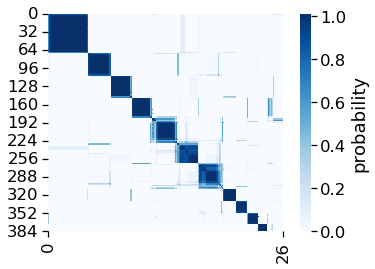

In [33]:
fig, ax = plt.subplots()
ax = sns.heatmap(coClust_matrix_sorted, cmap="Greys", ax=ax, cbar_kws={"drawedges": False, "label": 'probability'}, square=True)
ax.set_xticks((0,coClust_matrix_sorted.shape[0]));

### get original cluster labels

In [47]:
cluster_labels = pd.DataFrame(columns = ['labels', 'cell_specimen_id', 'cre_line'])
cluster_file_name = ''
for i, cre_line in enumerate(cre_lines):
    labels = cluster_labels_cre[cre_line]
    ids = cre_line_dfs[cre_line].index.values
    d = {'labels':labels, 'cell_specimen_id':ids, 'cre_line': [cre_line]*len(ids)}
    tmp = pd.DataFrame(data=d)
    cluster_labels = cluster_labels.append(tmp, ignore_index=True)
    cluster_file_name = cluster_file_name+'_'+cre_line.split('-')[0]+'_'+str(n_clusters_cre[i])
cluster_labels.to_hdf(os.path.join(save_dir, 'original_cluster_labels'+cluster_file_name+'.hdf'), key = 'df')

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->['labels', 'cell_specimen_id', 'cre_line']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


### reorder by cluster size to get final cluster IDs

In [108]:
# create new df with original labels and new cluster_id ordered by cluster size within each cre line
cluster_ids = pd.DataFrame()
cluster_file_name = ''
for cre_line in cre_lines: 
    cre_cluster_labels =  cluster_labels[cluster_labels.cre_line==cre_line]
    # count how many cells are in each label and get the order of original labels in descending size order - these are the new cluster IDs
    cre_cluster_order = cre_cluster_labels['labels'].value_counts().index.values
    # create new column with new cluster_id based on size of cluster
    cre_cluster_labels['cluster_id'] = [np.where(cre_cluster_order==label)[0][0] for label in cre_cluster_labels.labels.values]
    cluster_ids = pd.concat([cluster_ids, cre_cluster_labels])
    cluster_file_name = cluster_file_name+'_'+cre_line.split('-')[0]+'_'+str(n_clusters_cre[i])
cluster_ids.to_hdf(os.path.join(save_dir, 'cluster_ids'+cluster_file_name+'.hdf'), key = 'df')

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### plot feature matrix sorted by cluster ID

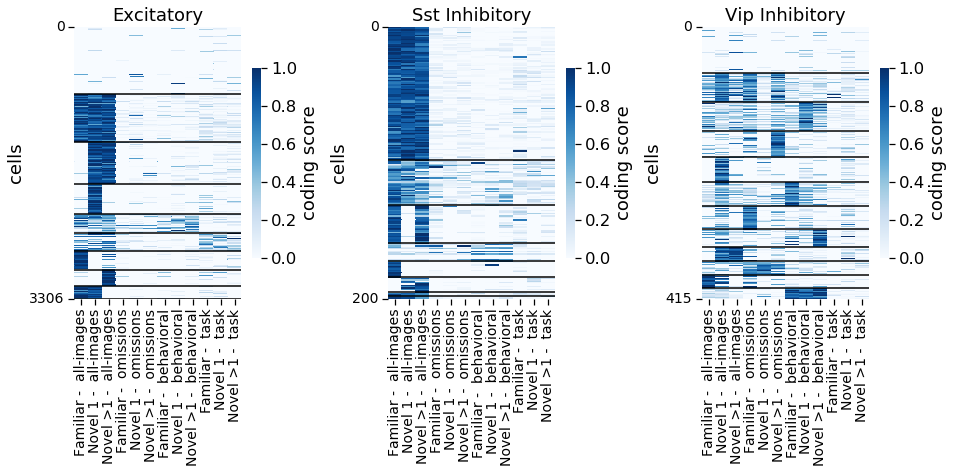

In [528]:
figsize = (15,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    cell_order = cluster_ids[cluster_ids.cre_line==cre_line].sort_values(by=['cluster_id']).cell_specimen_id.values
    label_values = cluster_ids[cluster_ids.cre_line==cre_line].sort_values(by=['cluster_id']).cluster_id.values
    data = df.loc[cell_order]
    ax[i] = sns.heatmap(data.values, cmap='Blues', ax=ax[i], vmin=0, vmax=1,
                     robust=True, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'coding score'})

    ax[i].set_title(cell_types[cre_line])
    ax[i].set_ylabel('cells')
    ax[i].set_ylim(0, data.shape[0])
    ax[i].set_yticks([0, data.shape[0]]);
    ax[i].set_yticklabels((0, data.shape[0]), fontsize=14);
    ax[i].set_ylim(ax[i].get_ylim()[::-1]) #flip y axes so larger clusters are on top
    ax[i].set_xlabel('')
    ax[i].set_xlim(0, data.shape[1])
    ax[i].set_xticks(np.arange(0, data.shape[1])+0.5)
    ax[i].set_xticklabels([key[1]+' -  '+key[0] for key in list(data.keys())], rotation=90, fontsize=14);

    cluster_divisions = np.where(np.diff(label_values)==1)[0]
    for y in cluster_divisions:
        ax[i].hlines(y, xmin=0, xmax=df.shape[1], color='k')

fig.subplots_adjust(wspace=0.5)
utils.save_figure(fig, figsize, base_dir, folder, 'feature_matrix_sorted_by_cluster_id')

### umap with cluster labels

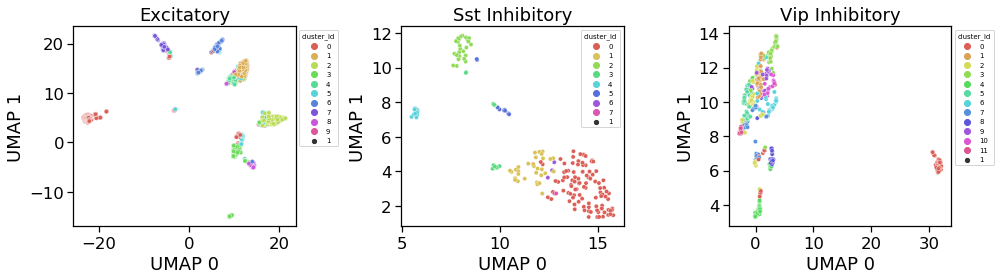

In [621]:
# for column in ['project_code', 'binned_depth', 'targeted_structure', 'mouse_id']:
column = 'cluster_id'

figsize = (14,4)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    cre_meta = cluster_ids[cluster_ids.cre_line==cre_line]
    cell_specimen_ids = cre_meta.cell_specimen_id.values
    n_cols = len(cre_meta['cluster_id'].unique())
    palette = sns.color_palette('hls', n_cols)
    X = df.loc[cell_specimen_ids]
    fit = umap.UMAP()
    u = fit.fit_transform(X)
    labels = [cluster_ids[cluster_ids.cell_specimen_id==cell_specimen_id][column].values[0] for cell_specimen_id in cell_specimen_ids]
    umap_df = pd.DataFrame()
    umap_df['x'] = u[:, 0]
    umap_df['y'] = u[:, 1]
    umap_df['labels'] = labels
    ax[i] = sns.scatterplot(data=umap_df, x='x', y='y', hue='labels', size=1, ax=ax[i], palette=palette )
    ax[i].set_xlabel('UMAP 0')
    ax[i].set_ylabel('UMAP 1')
    ax[i].legend(fontsize='x-small', title=column, title_fontsize='x-small', bbox_to_anchor=(1,1))
    ax[i].set_title(cell_types[cre_line])
fig.tight_layout()
utils.save_figure(fig, figsize, base_dir, folder, 'UMAP')

### Correlations within clusters

In [216]:
cell_types={}
for cre_line in cre_lines:
    cell_types[cre_line] = experiments_table[experiments_table.cre_line==cre_line].cell_type.unique()[0]

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\funct

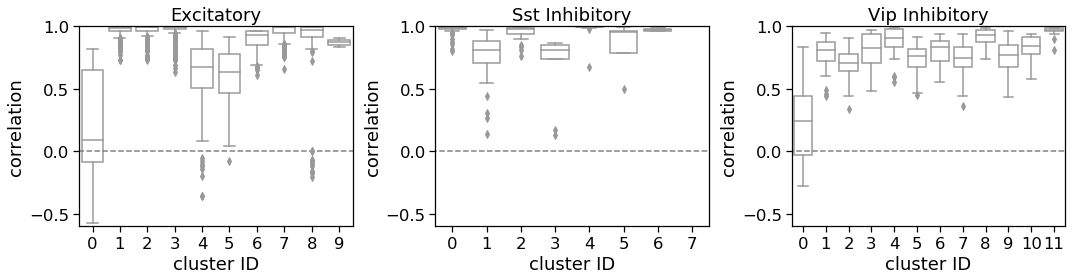

In [290]:
figsize = (15,3)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i,cre_line in enumerate(cre_lines):
    cell_specimen_ids = df_meta[df_meta.cre_line==cre_line].index.values
    df_dropouts = df.loc[cell_specimen_ids]
    labels_df = cluster_ids.set_index('cell_specimen_id').loc[cell_specimen_ids]
    cluster_corrs = vba_clust.get_cluster_density(df_dropouts, labels_df, label_col='cluster_id')
    df_labels = pd.DataFrame(columns=['corr', 'labels'])
    for key in cluster_corrs.keys():
        data = np.array([cluster_corrs[key], np.repeat(key, len(cluster_corrs[key]))])
        tmp = pd.DataFrame(data.transpose(), columns=['corr', 'labels'])
        df_labels = df_labels.append(tmp, ignore_index=True)
    df_labels['labels'] = [int(label) for label in df_labels.labels.values]
    ax[i].axhline(xmin=-1, xmax=max(cluster_corrs.keys()) + 1, color='grey', linestyle='--')
    ax[i] = sns.boxplot(data=df_labels, x='labels', y='corr', ax=ax[i], color='white')
    ax[i].set_title(cell_types[cre_line])
    ax[i].set_ylabel('correlation')
    ax[i].set_xlabel('cluster ID')
    ax[i].set_ylim(-0.6, 1)
fig.tight_layout()  
utils.save_figure(fig, figsize, base_dir, folder, 'correlations_within_clusters')

<a id='1p3'></a>
### 1.3 Plot Clusters

### average dropouts per cre line

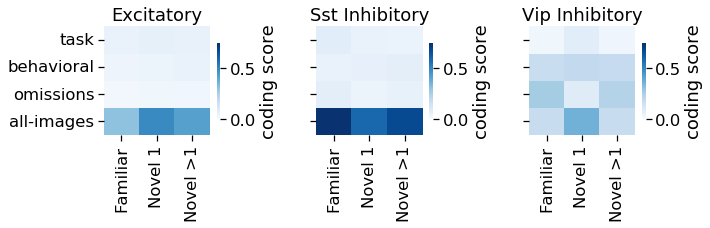

In [487]:
dropouts = rspm.merge(cells_table[['cell_specimen_id', 'cre_line', 'binned_depth', 'targeted_structure']], on='cell_specimen_id')

fig, ax = plt.subplots(1,3, figsize=(10,2), sharex=True, sharey=True)
ax = ax.ravel()
for i, cre_line in enumerate(cre_lines):
    mean_dropouts = dropouts[dropouts.cre_line==cre_line].groupby('experience_level').mean()[features]
    ax[i] = sns.heatmap(mean_dropouts.T, cmap='Blues', vmin=0, vmax=0.75, ax=ax[i], cbar_kws={'shrink':0.7, 'label':'coding score'})
    ax[i].set_title(cell_types[cre_line])
    ax[i].set_ylim(0, 4)
    ax[i].set_xlabel('')
plt.subplots_adjust(wspace=0.6)

### average dropouts for all cells, not just cells in clusters

In [520]:
# full_results_pivoted = gat.build_pivoted_results_summary(value_to_use=model_output_type, results_summary=None,
#                                              glm_version=glm_version, cutoff=None)


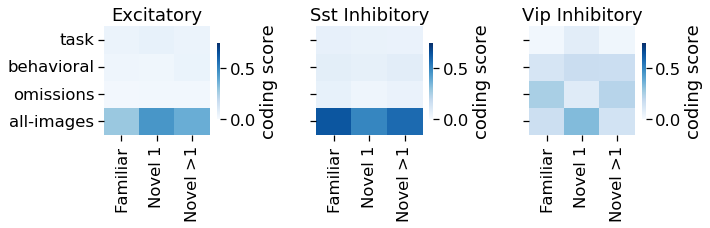

In [531]:
dropouts = full_results_pivoted.copy()

fig, ax = plt.subplots(1,3, figsize=(10,2), sharex=True, sharey=True)
ax = ax.ravel()
for i, cre_line in enumerate(cre_lines):
    mean_dropouts = dropouts[dropouts.cre_line==cre_line].groupby('experience_level').mean()[features]
    ax[i] = sns.heatmap(np.abs(mean_dropouts.T), cmap='Blues', vmin=0, vmax=0.75, ax=ax[i], cbar_kws={'shrink':0.7, 'label':'coding score'})
    ax[i].set_title(cell_types[cre_line])
    ax[i].set_ylim(0, 4)
    ax[i].set_xlabel('')
plt.subplots_adjust(wspace=0.6)

### plot cluster heatmaps as a grid for each cre line 

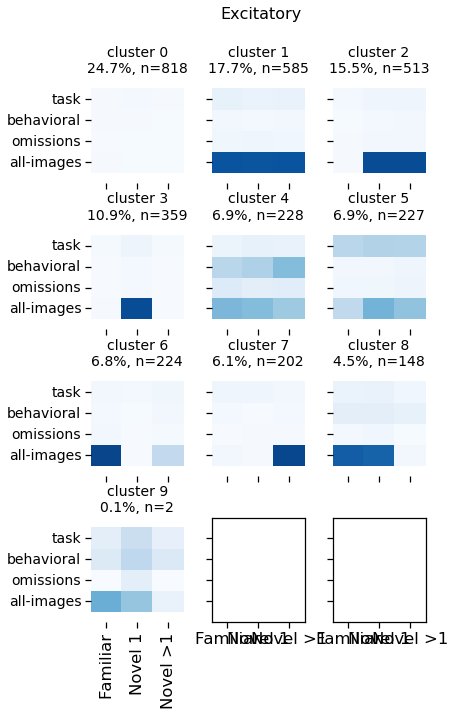

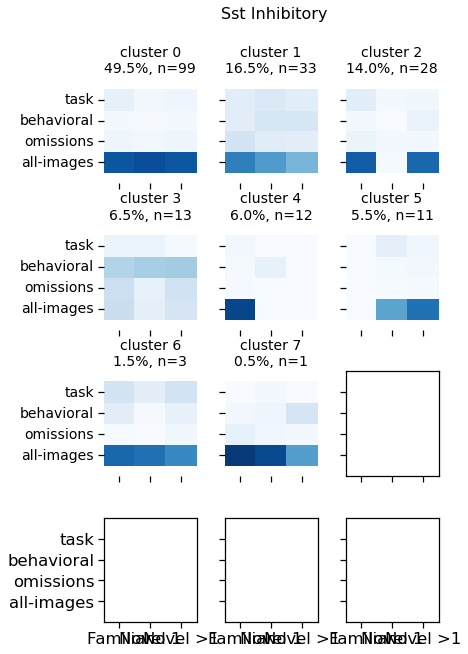

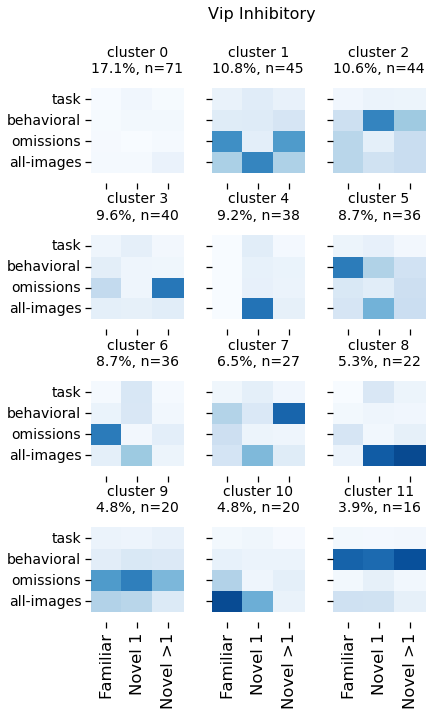

In [309]:
for cre_line in cre_lines:

    # get cell specimen ids for this cre line
    cre_cell_specimen_ids = df_meta[df_meta.cre_line==cre_line].index.values
    # get cluster labels dataframe for this cre line
    cre_cluster_ids = cluster_ids[cluster_ids.cell_specimen_id.isin(cre_cell_specimen_ids)]
    # get unique cluster labels for this cre line
    cluster_labels = np.sort(cre_cluster_ids.cluster_id.unique())
    n_clusters = len(cluster_labels)

    figsize = (6,10)
    fig, ax = plt.subplots(4, 3, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    # limit dropouts df to cells in this cre line
    df_cre = df.loc[cre_cell_specimen_ids]
    for i, cluster_id in enumerate(cluster_labels):
        # get cell specimen ids in this cluster in this cre line
        this_cluster_csids = cre_cluster_ids[cre_cluster_ids['cluster_id'] == cluster_id].cell_specimen_id.values
        # get dropout scores for cells in this cluster in this cre line
        mean_dropout_df = np.abs(df_cre.loc[this_cluster_csids].mean().unstack())
        ax[i] = sns.heatmap(mean_dropout_df, cmap='Blues', vmin=0, vmax=1, ax=ax[i], cbar=False)
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cre = len(this_cluster_csids) / float(len(cre_cell_specimen_ids))
        fraction = np.round(fraction_cre * 100, 1)

        # set title and labels
        ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)), fontsize=14)
        ax[i].set_yticklabels(mean_dropout_df.index.values, rotation=0, fontsize=14)
        ax[i].set_ylim(-0.5, 4.5)
        ax[i].set_xlabel('')
    # fig.tight_layout()
    plt.suptitle(cell_types[cre_line], x=0.52, y=.98, fontsize=16)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    utils.save_figure(fig, figsize, base_dir, folder, 'cluster_heatmaps_'+cre_line)

In [ ]:
# cre_line = cre_lines[1]

# cluster_df = clustered_df[clustered_df.cre_line==cre_line]
# cluster_df = cluster_df.rename(columns={'labels':'cluster_id'})

# cluster_ids = cluster_df['cluster_id'].value_counts().index.values  # sort cluster ids by size
# n_clusters = len(cluster_ids)

# fig, ax = plt.subplots(int(n_clusters/3)+1, 3, figsize=(6,8), sharex=True, sharey=True)
# ax = ax.ravel()

# df_sel = cre_line_dfs[cre_line]
# for i, cluster_id in enumerate(cluster_ids):

#     # 1. Mean dropout scores
#     this_cluster_ids = cluster_df[cluster_df['cluster_id'] == cluster_id]['cell_specimen_id'].unique()
#     mean_dropout_df = np.abs(df_sel.loc[this_cluster_ids].mean().unstack())
#     ax[i] = sns.heatmap(mean_dropout_df, cmap='Reds', vmin=0, vmax=1, ax=ax[i],cbar=False)

#     within_cluster_df = cluster_df[cluster_df['cluster_id'] == cluster_id].drop_duplicates('cell_specimen_id').groupby('cre_line').count()[['cluster_id']]
#     n_cells = within_cluster_df.sum().values[0]
#     all_df = cluster_df.drop_duplicates('cell_specimen_id').groupby('cre_line').count()[['cluster_id']]
#     fraction_cre = within_cluster_df / all_df
#     fraction_cre.sort_index(inplace=True)
#     # add numerical column for sns.barplot
#     fraction_cre['cell_type_index'] = np.arange(0, fraction_cre.shape[0])
#     fraction = np.round(fraction_cre[['cluster_id']].values * 100, 1)

#     # set title and labels
#     ax[i].set_title('cluster ' + str(i) + '\n' + str(fraction[0][0]) + '%, n=' + str(n_cells), fontsize=16)
#     ax[i].set_yticklabels(mean_dropout_df.index.values, rotation=0)
#     ax[i].set_ylim(-0.5, 4.5)
#     ax[i].set_xlabel('')
# # fig.tight_layout()
# plt.suptitle(cell_types[cre_line], x=0.52, y=1)
# plt.subplots_adjust(hspace=0.4, wspace=0.3)

### plot cluster heatmaps with other information

#### get multi session mean df

In [ ]:
# load dataframe with response traces
df_name = 'omission_response_df'
conditions = ['cell_specimen_id', 'omitted']

data_type = 'events'
event_type = 'omissions'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'


multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)
print(len(multi_session_df.ophys_experiment_id.unique()))

In [ ]:
timestamps = multi_session_df.trace_timestamps.values[0]

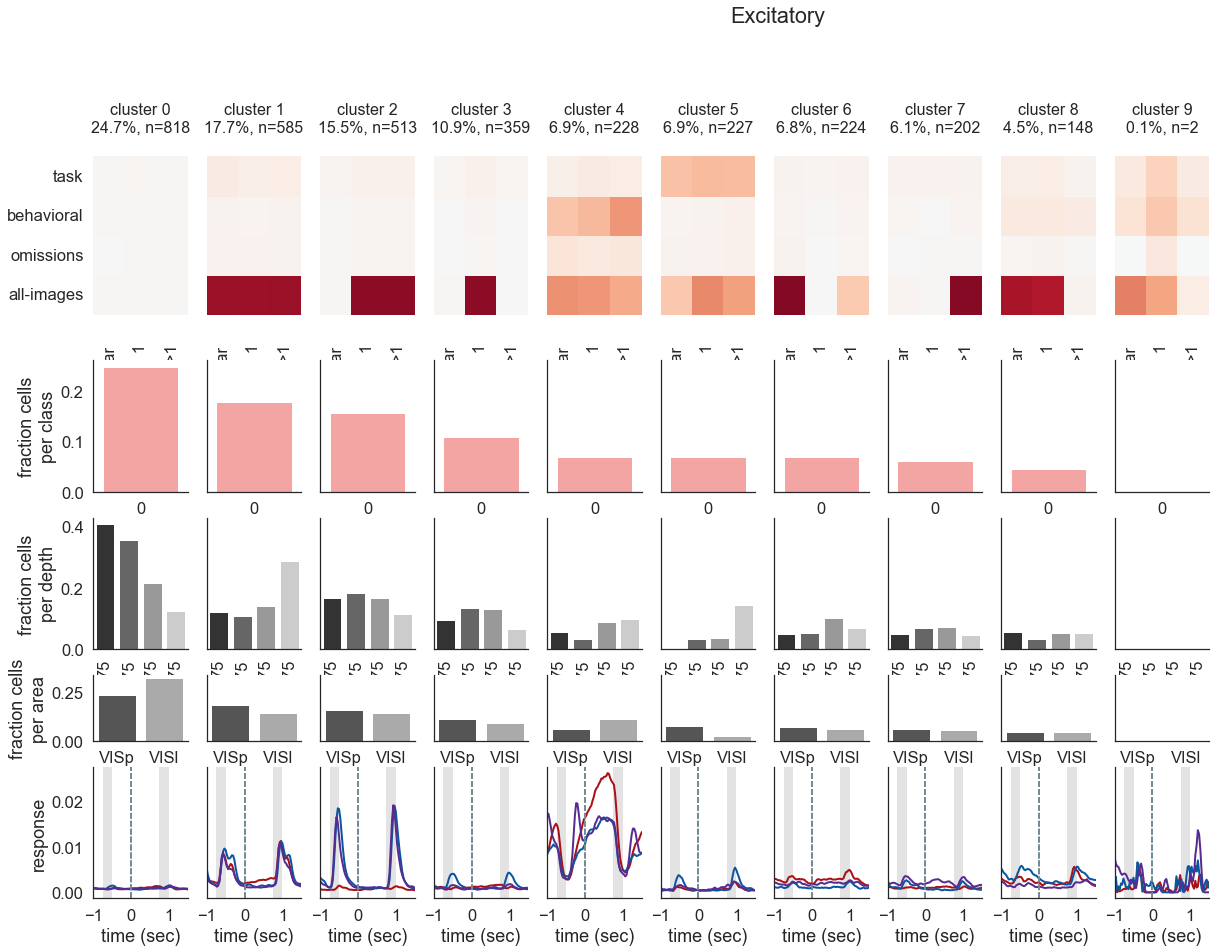

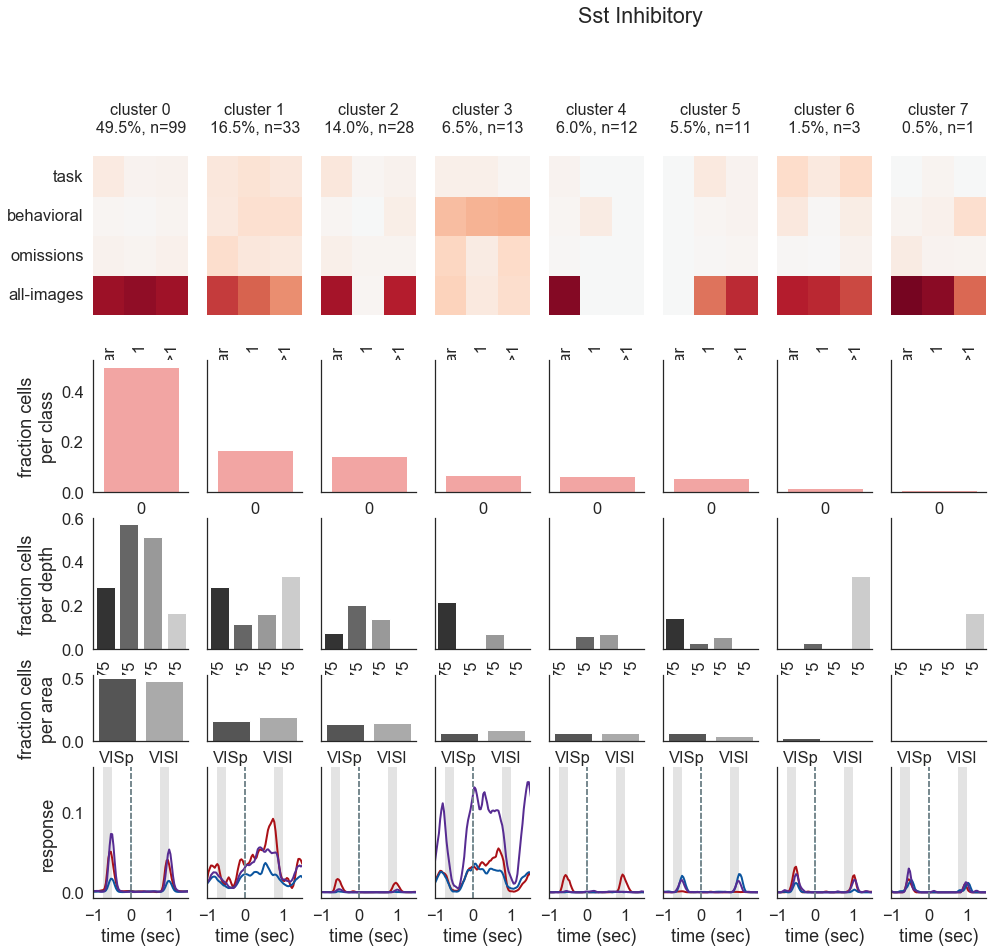

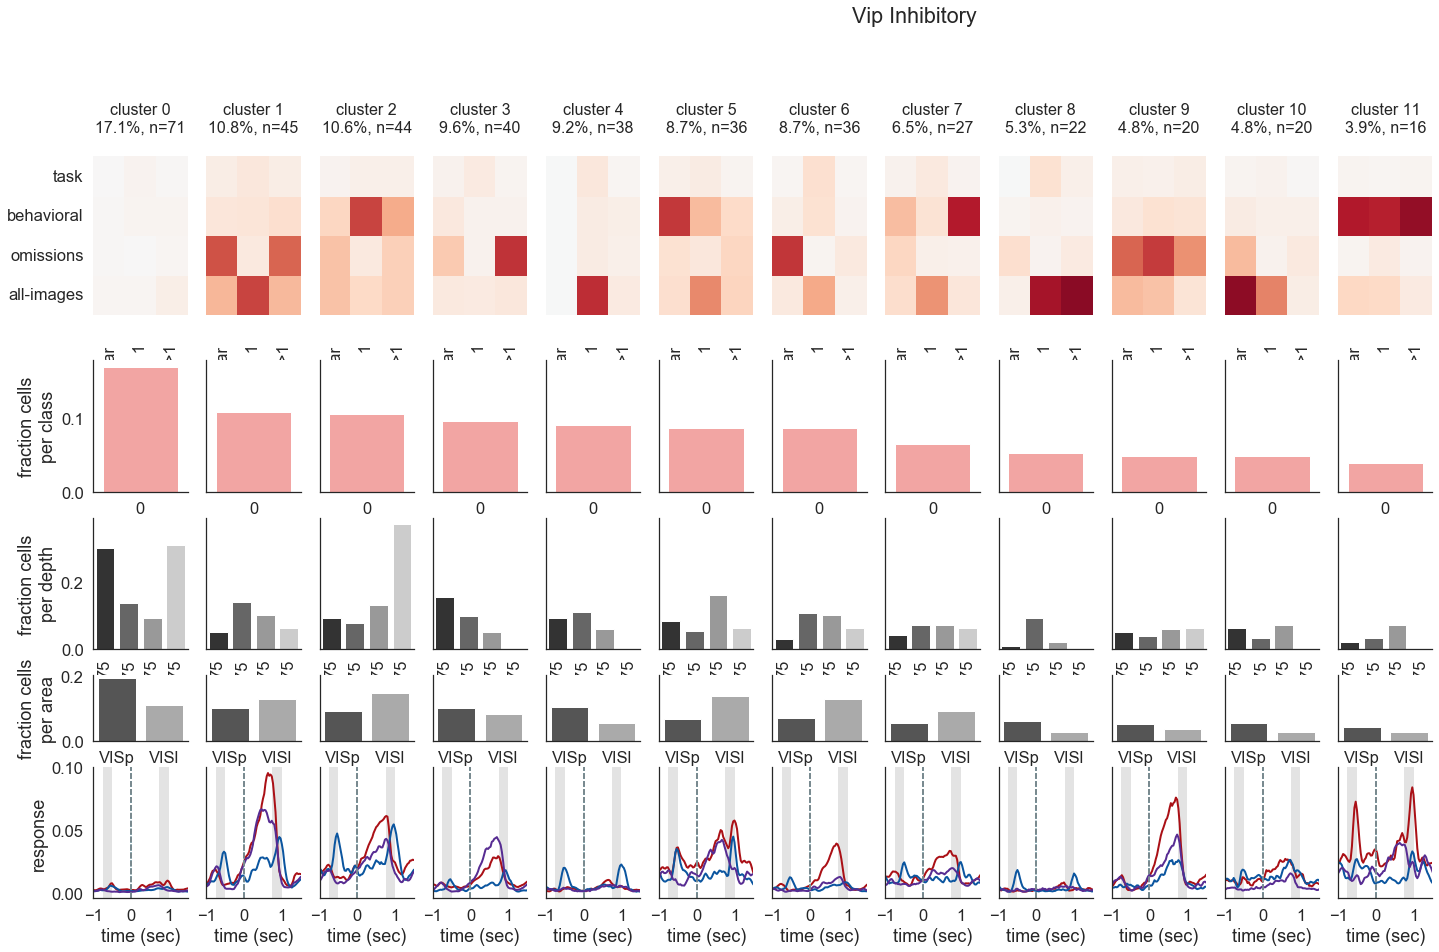

In [246]:
for i, cre_line in enumerate(cre_lines):
    df_sel = cre_line_dfs[cre_line]
    labels = cluster_labels_cre[cre_line]
    cre_cluster_df = pd.DataFrame(index = df_sel.index, columns = ['cluster_id'], data =labels)
    cre_cluster_df.reset_index(inplace=True)
    len(cluster_df)
    cluster_mdf = multi_session_df.merge(cre_cluster_df[['cell_specimen_id', 'cluster_id']], 
                                     on='cell_specimen_id',
                                     how = 'inner')
    len(cluster_mdf)
    
    fig_name='cluster_plots_{}_{}'.format(cre_line, glm_version)
    fig_namefile = os.path.join(save_dir, fig_name+'.png')
    ax = vba_clust.plot_clusters(df_sel, cluster_mdf)
    plt.suptitle(cell_types[cre_line], x=0.55, y=1.01)
#     plt.tight_layout()
    ax.savefig(fig_namefile)
   

### average dropouts per cre line 

In [ ]:
dropouts = rspm.merge(cells_table[['cell_specimen_id', 'cre_line', 'binned_depth', 'targeted_structure']], on='cell_specimen_id')

fig, ax = plt.subplots(1,3, figsize=(10,2), sharex=True, sharey=True)
ax = ax.ravel()
for i, cre_line in enumerate(cre_lines):
    mean_dropouts = dropouts[dropouts.cre_line==cre_line].groupby('experience_level').mean()[features]
    ax[i] = sns.heatmap(mean_dropouts.T, cmap='Blues', vmin=0, vmax=0.75, ax=ax[i], cbar_kws={'shrink':0.7, 'label':'coding score'})
    ax[i].set_title(cell_types[cre_line])
    ax[i].set_ylim(0, 4)
    ax[i].set_xlabel('')
plt.subplots_adjust(wspace=0.6)

### plot all cells per cluster

In [516]:
def get_session_info(metadata):
    m = metadata.copy()
    metadata_string = 'mouse_'+str(m['mouse_id']) + '_session_' + str(m['ophys_session_id'])+'_'+m['cre_line'].split('-')[0] + '_' + m['session_type']
    return metadata_string

def get_area_depth(metadata):
    m = metadata.copy()
    metadata_string = m['targeted_structure'] + '_' + str(m['imaging_depth'])
    return metadata_string

experience_levels = np.sort(cells_table.experience_level.unique())

988 cells in cluster 0
selecting a random subset of 100
274 cells in cluster 5
selecting a random subset of 100
412 cells in cluster 3
selecting a random subset of 100
170 cells in cluster 8
selecting a random subset of 100
585 cells in cluster 2
selecting a random subset of 100
663 cells in cluster 1
selecting a random subset of 100
278 cells in cluster 4
selecting a random subset of 100
230 cells in cluster 7
selecting a random subset of 100
263 cells in cluster 6
selecting a random subset of 100
22 cells in cluster 9
selecting a random subset of 100


ValueError: Sample larger than population or is negative

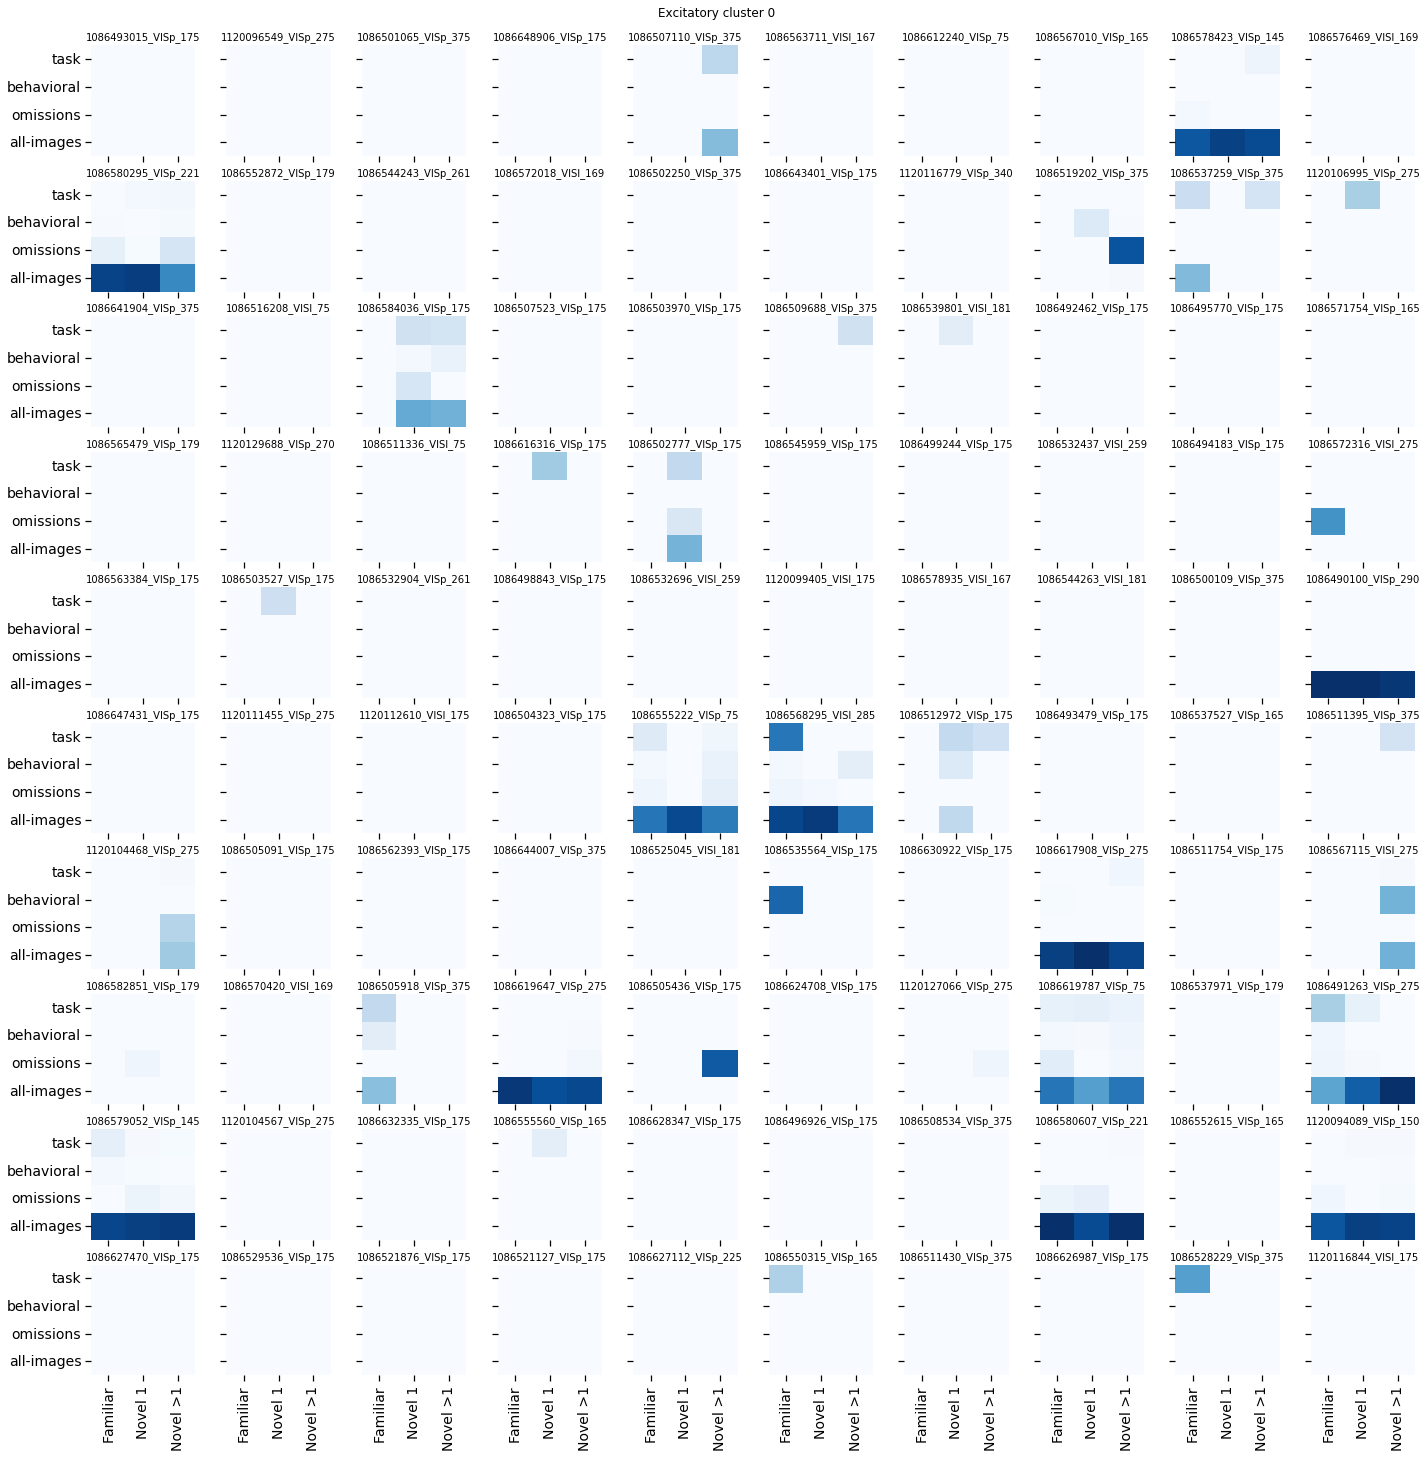

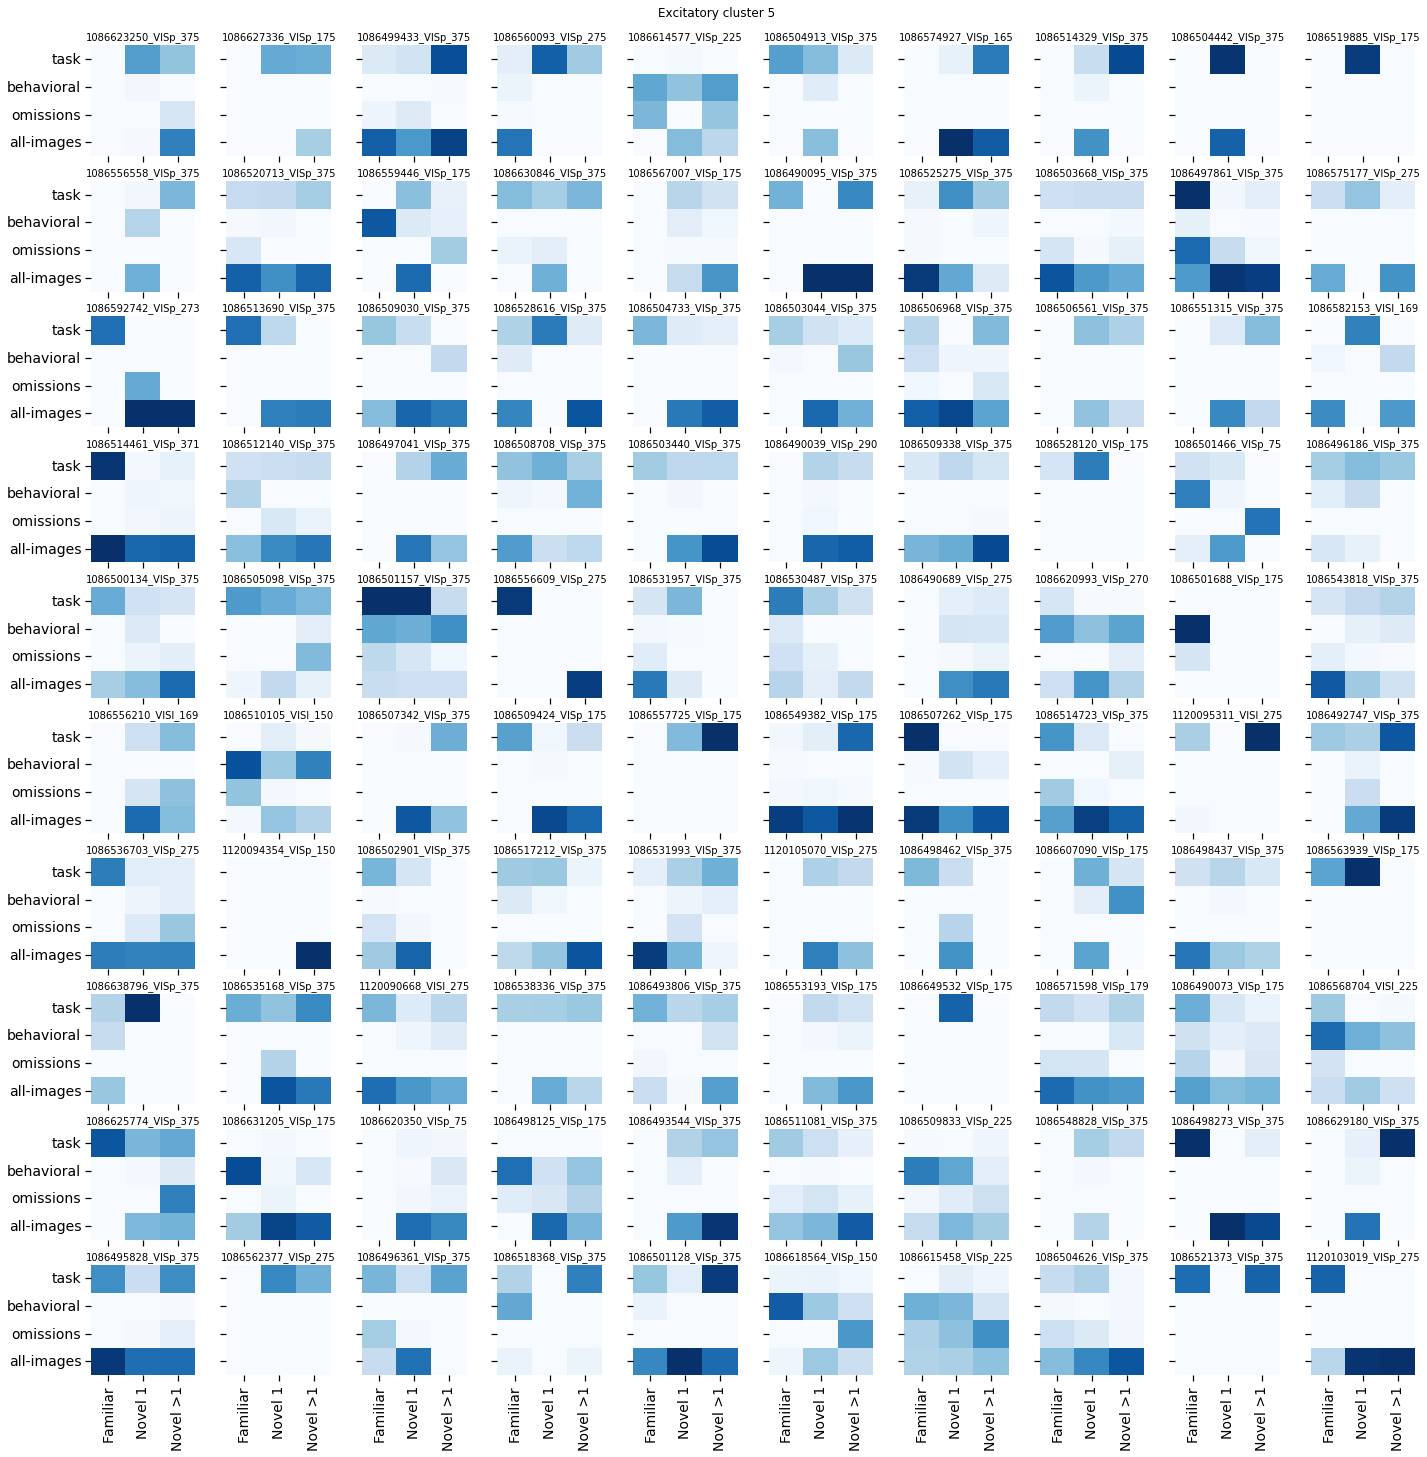

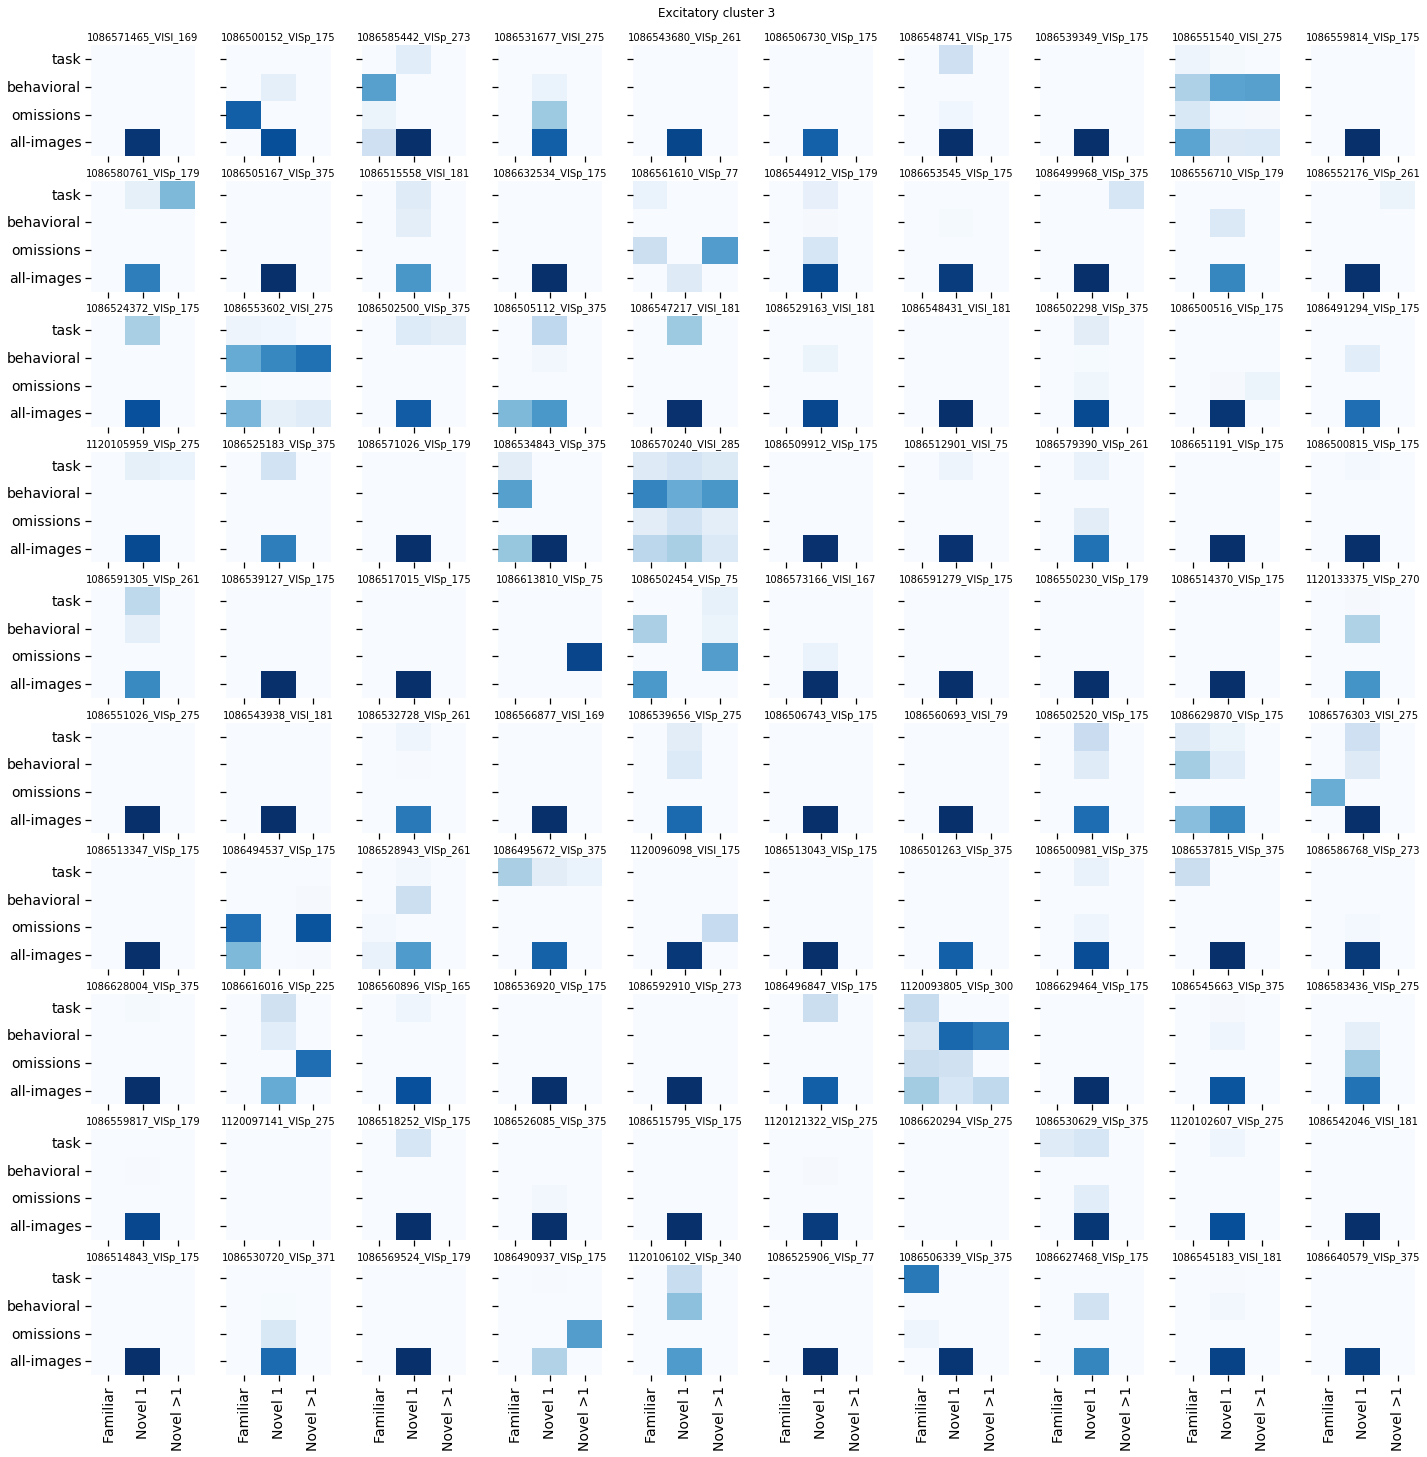

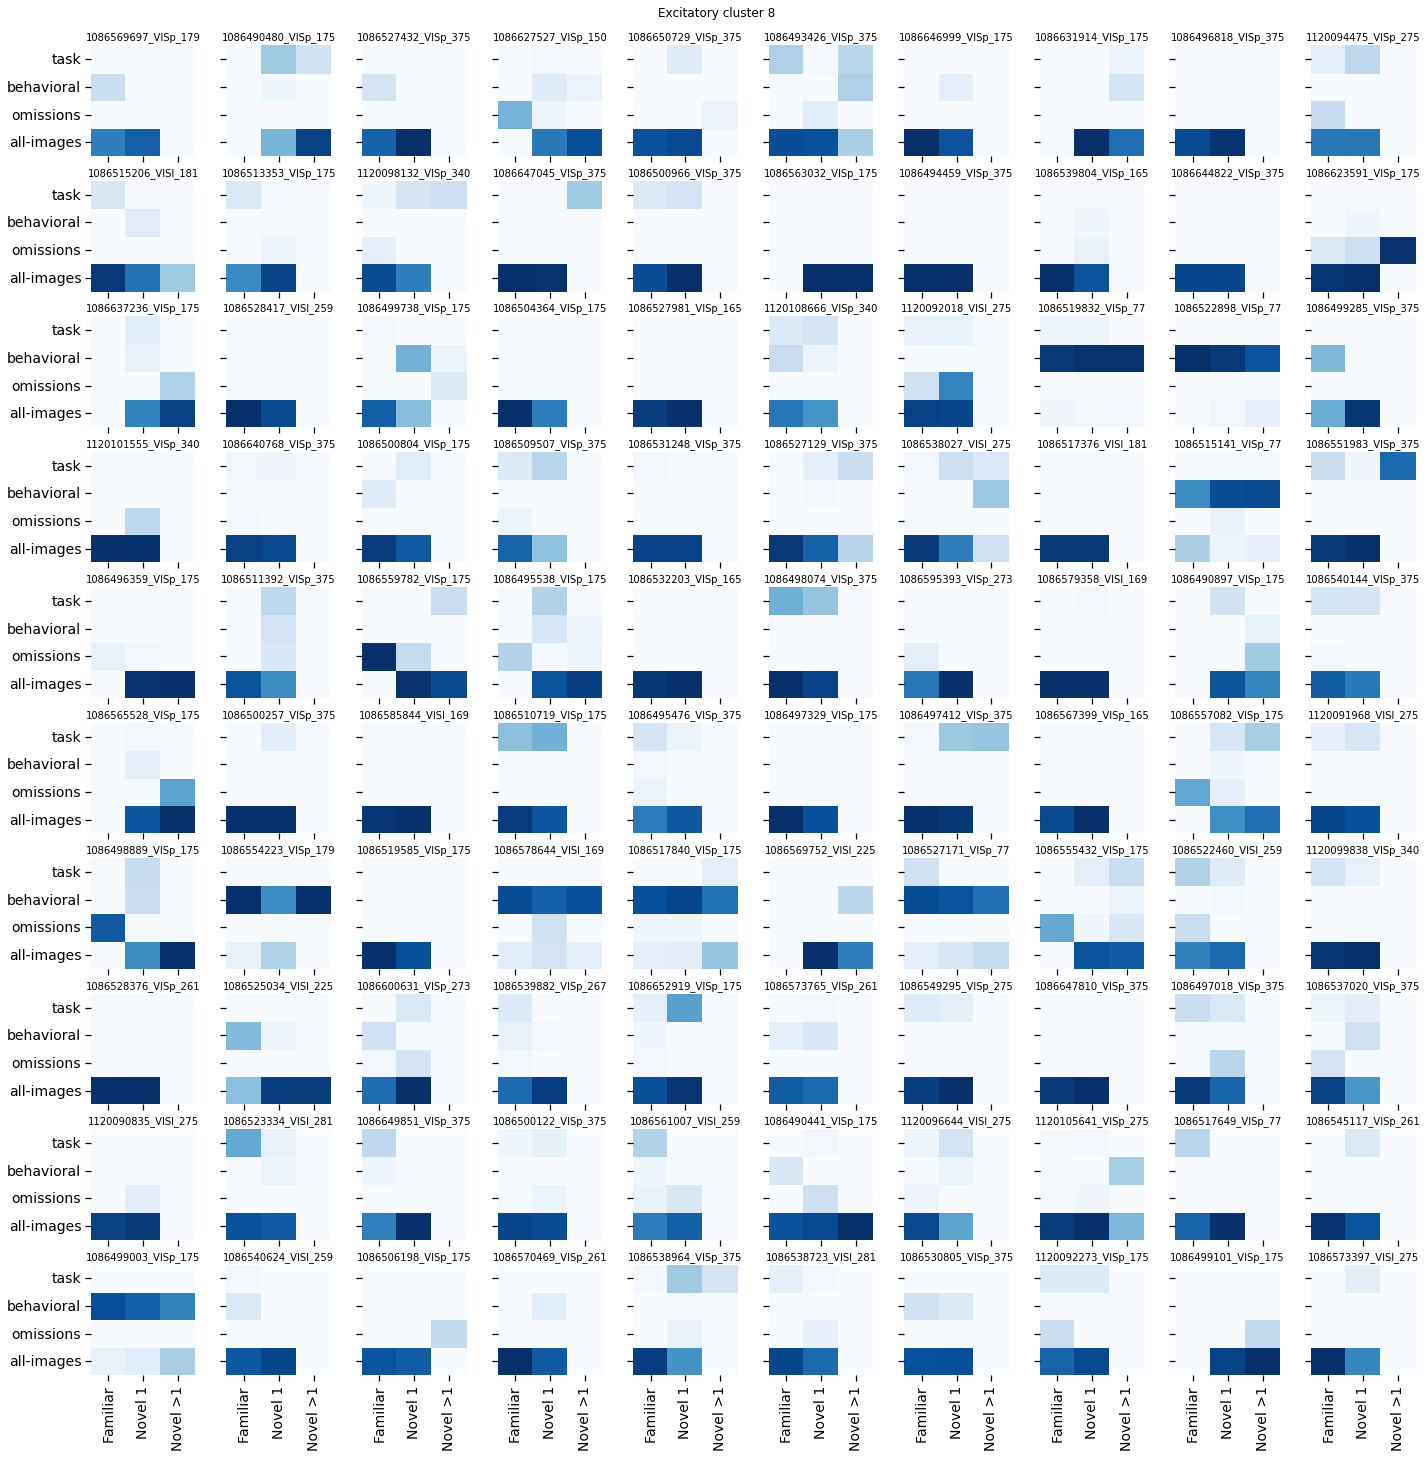

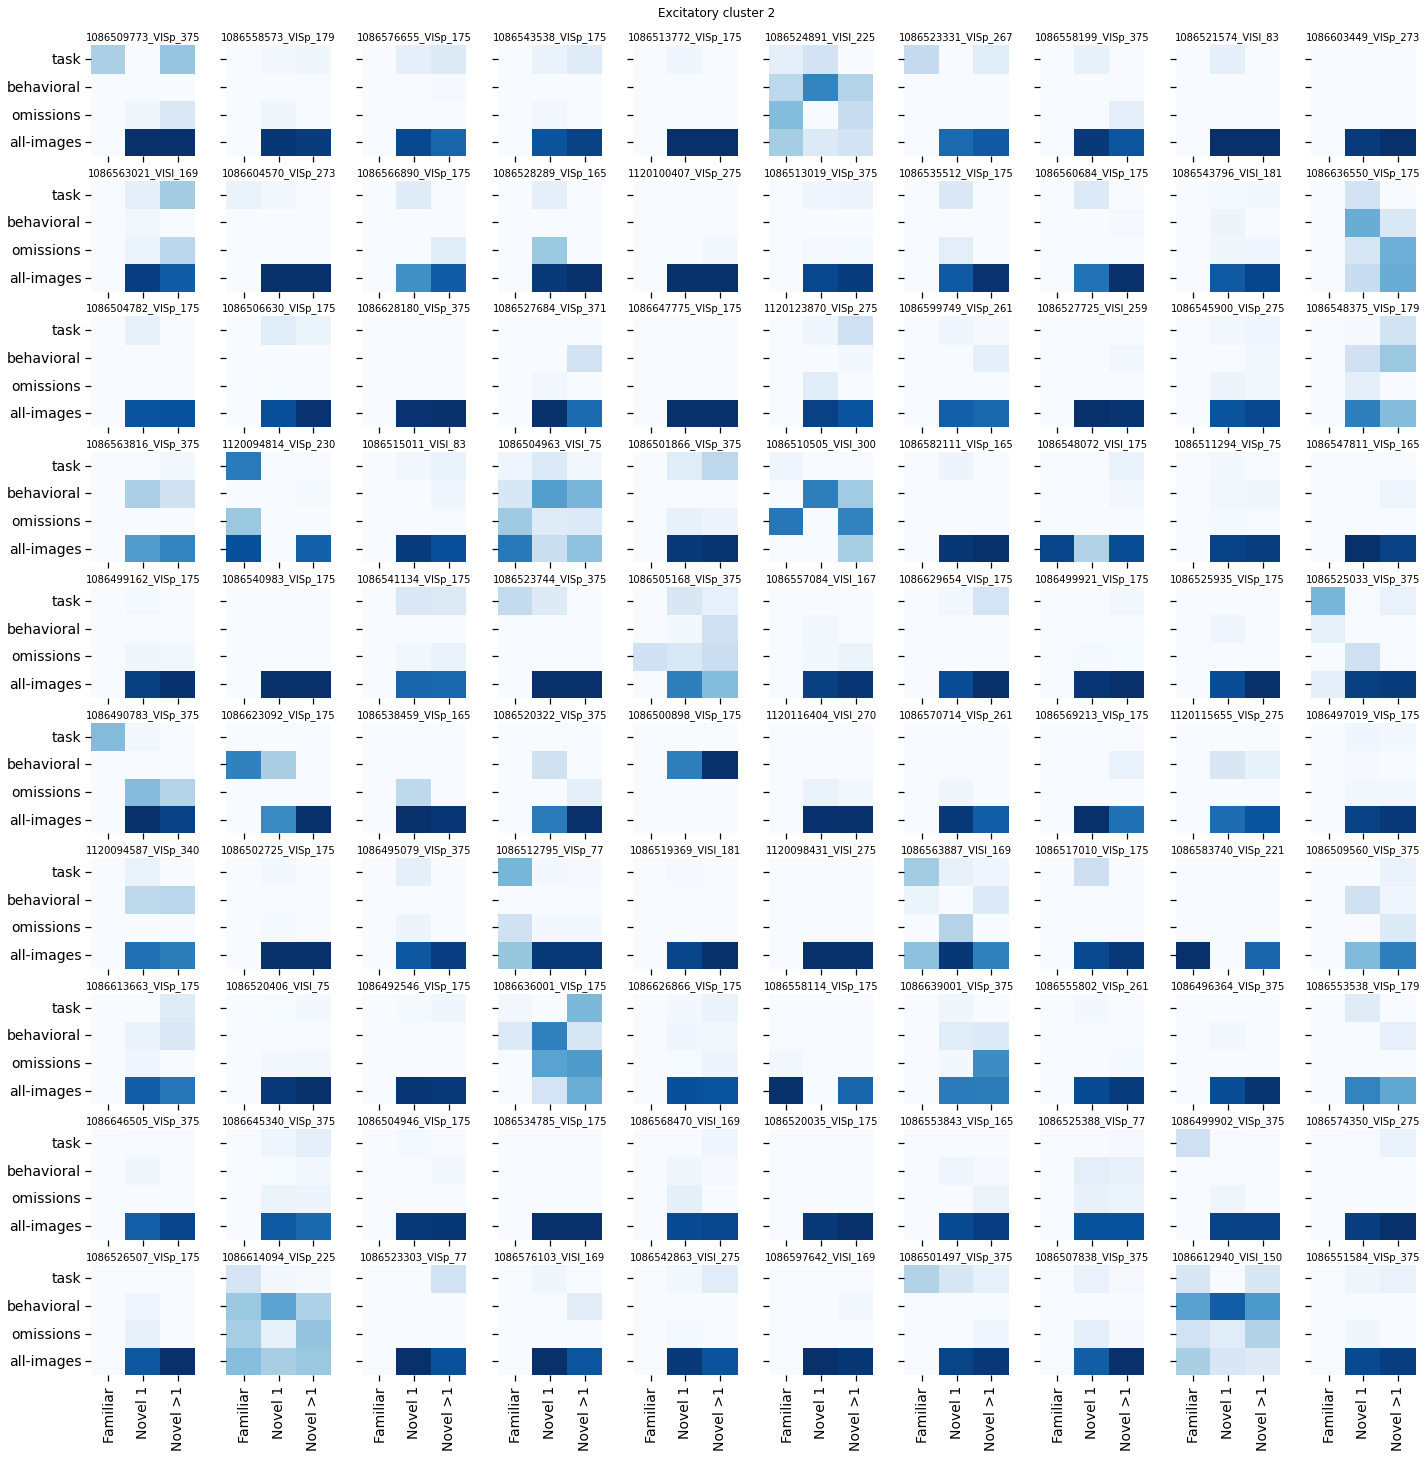

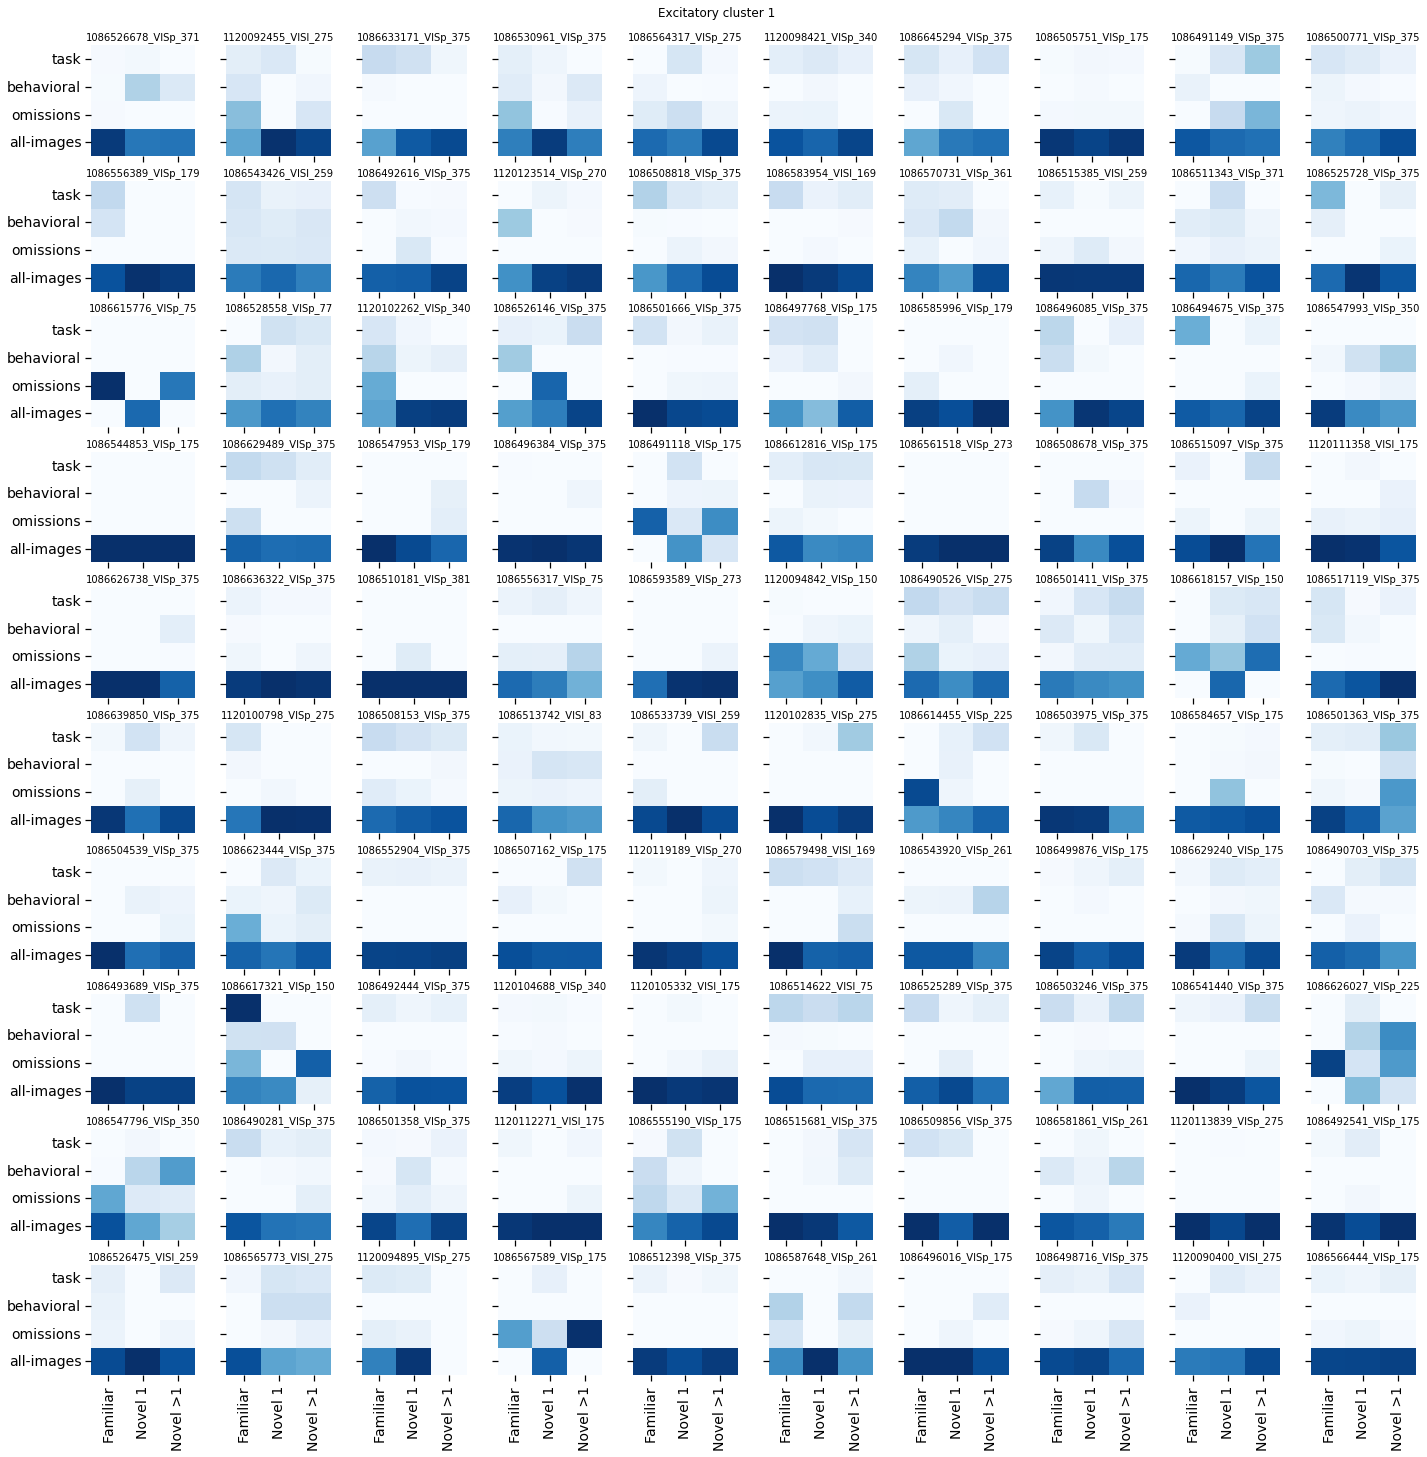

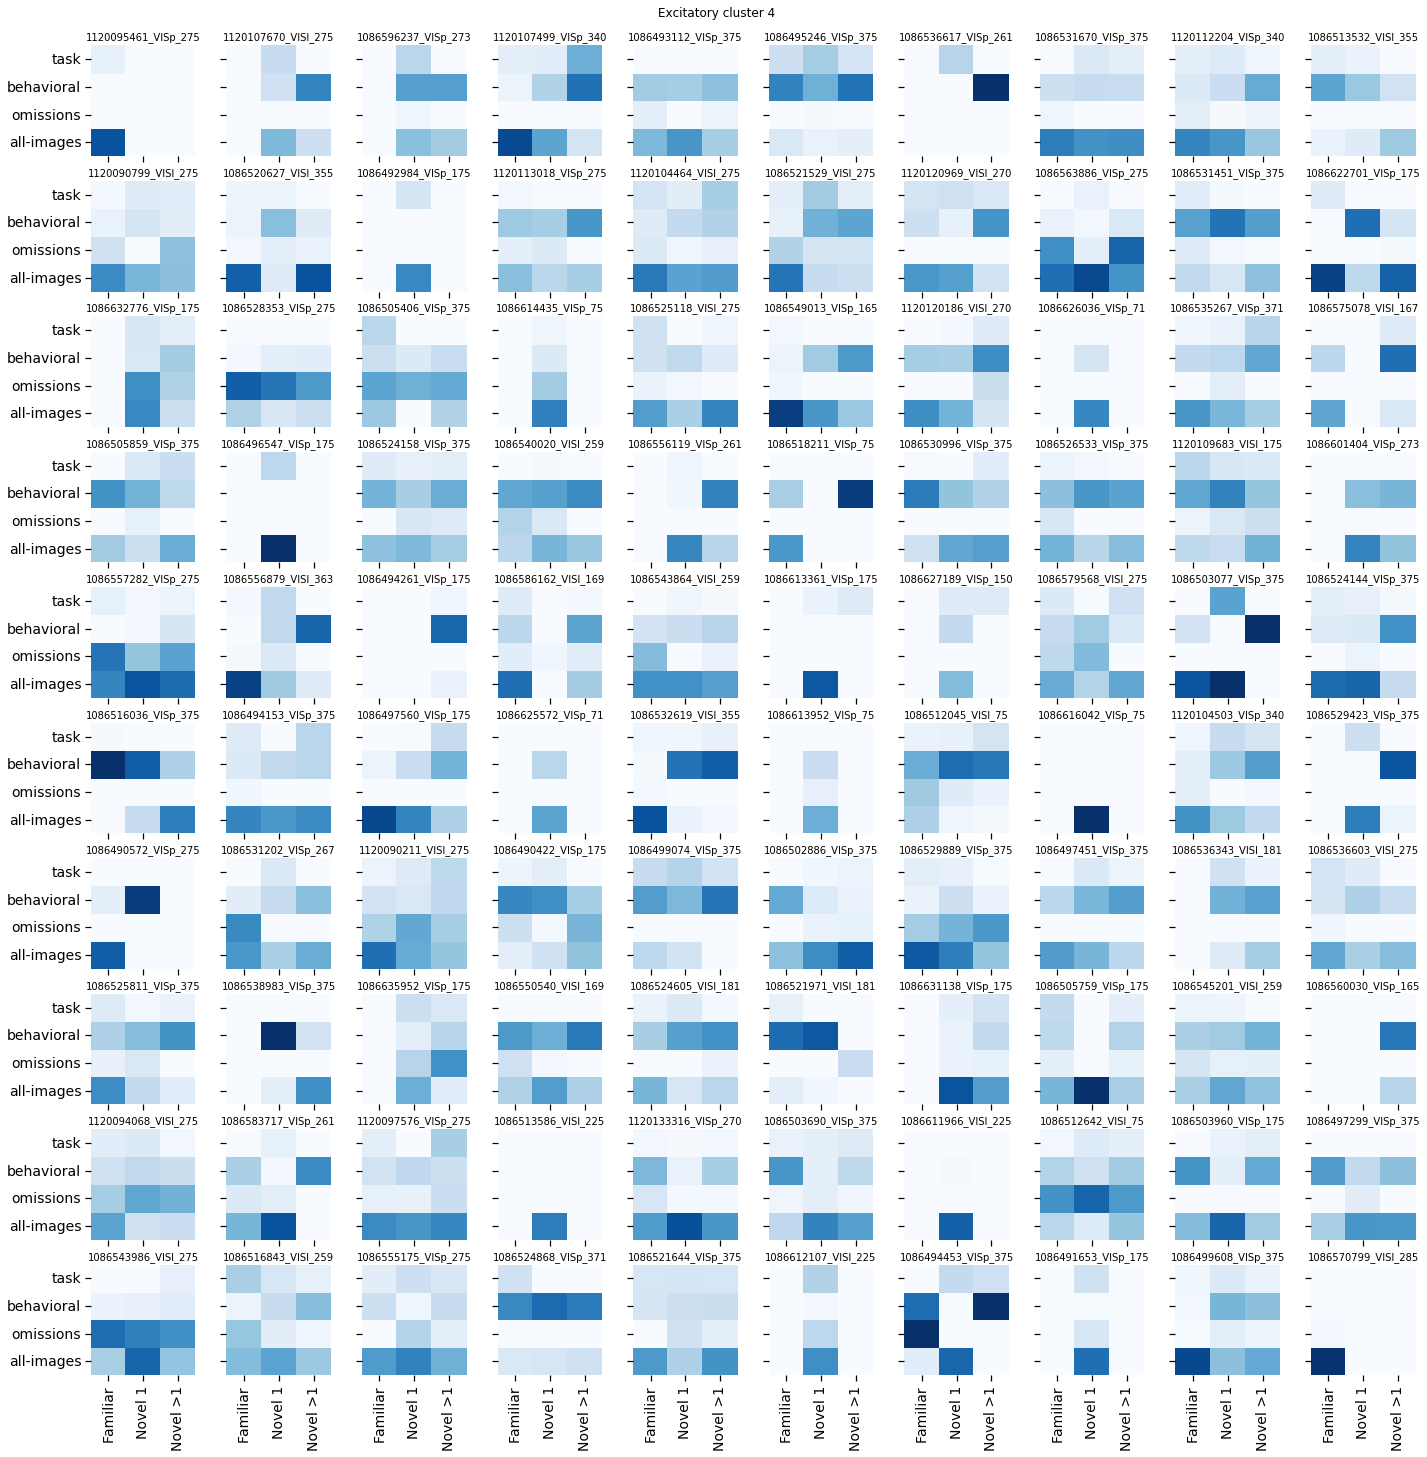

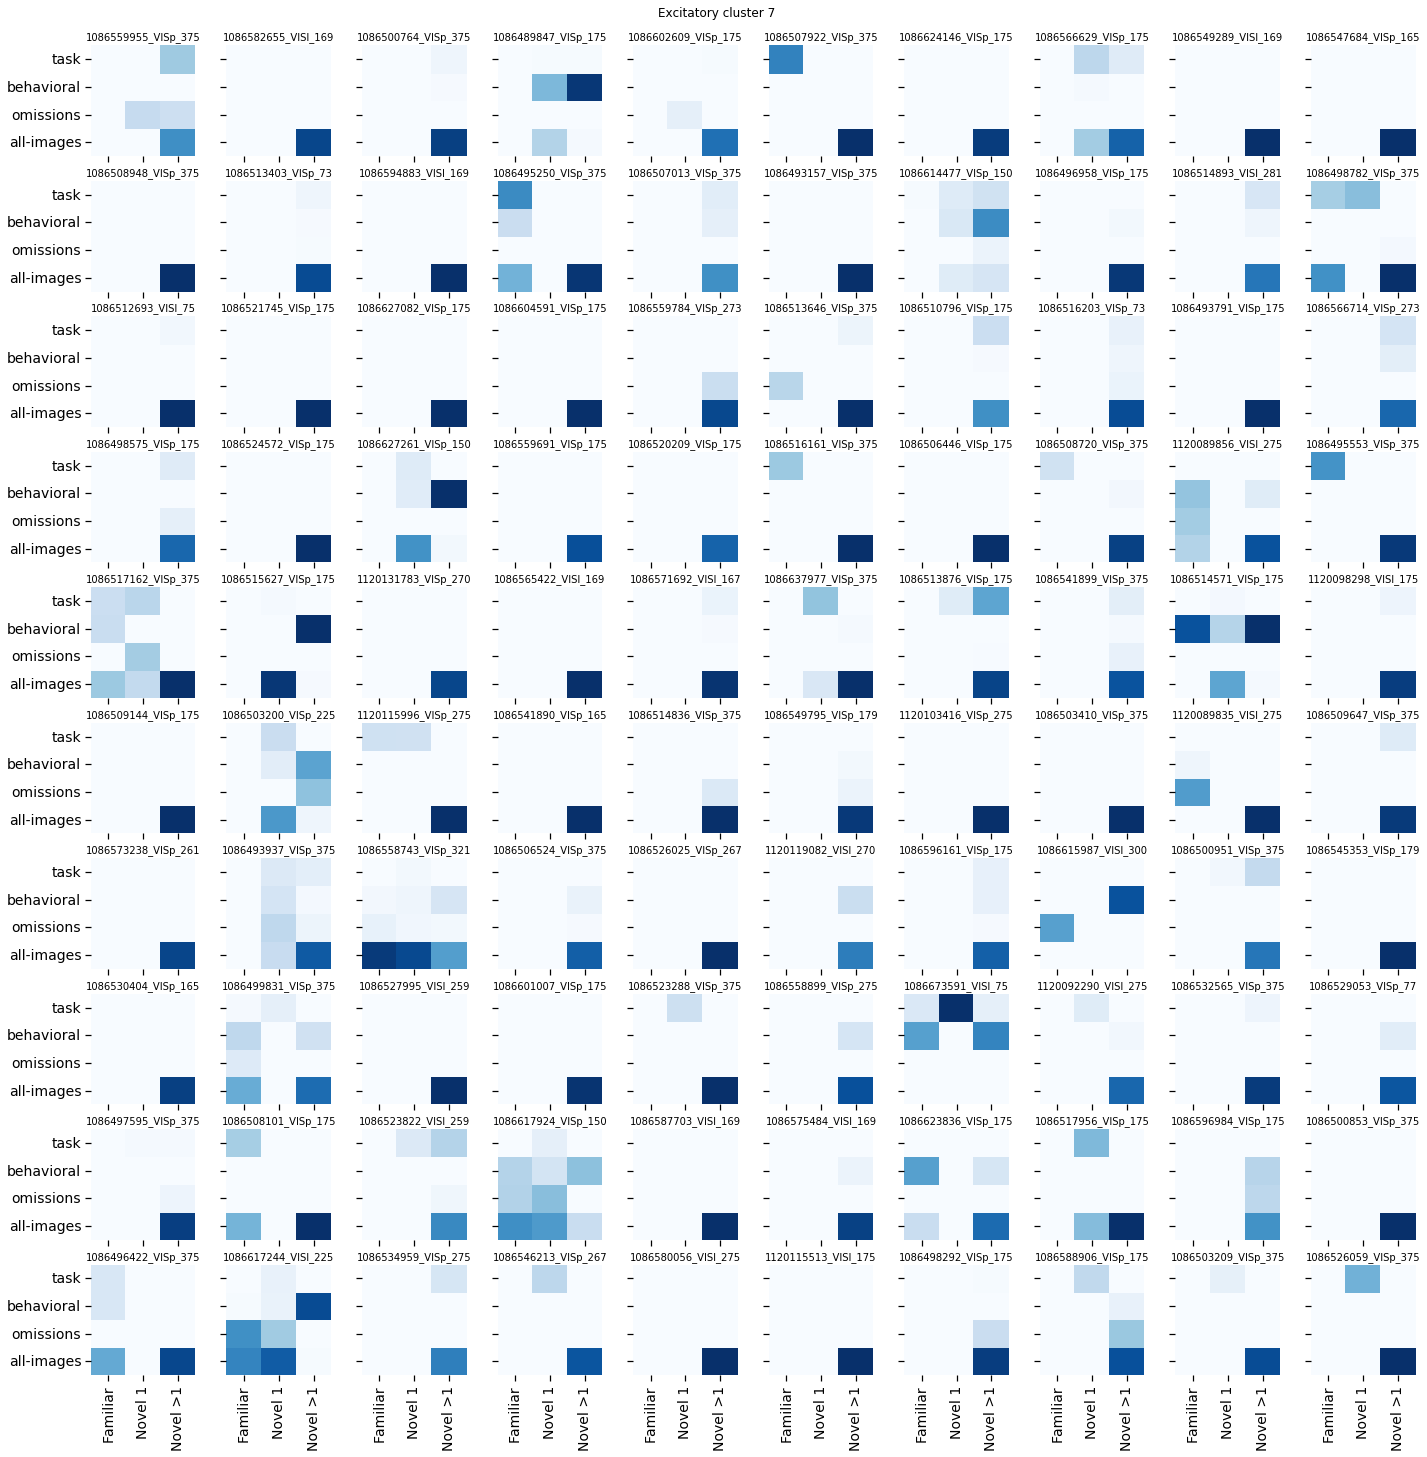

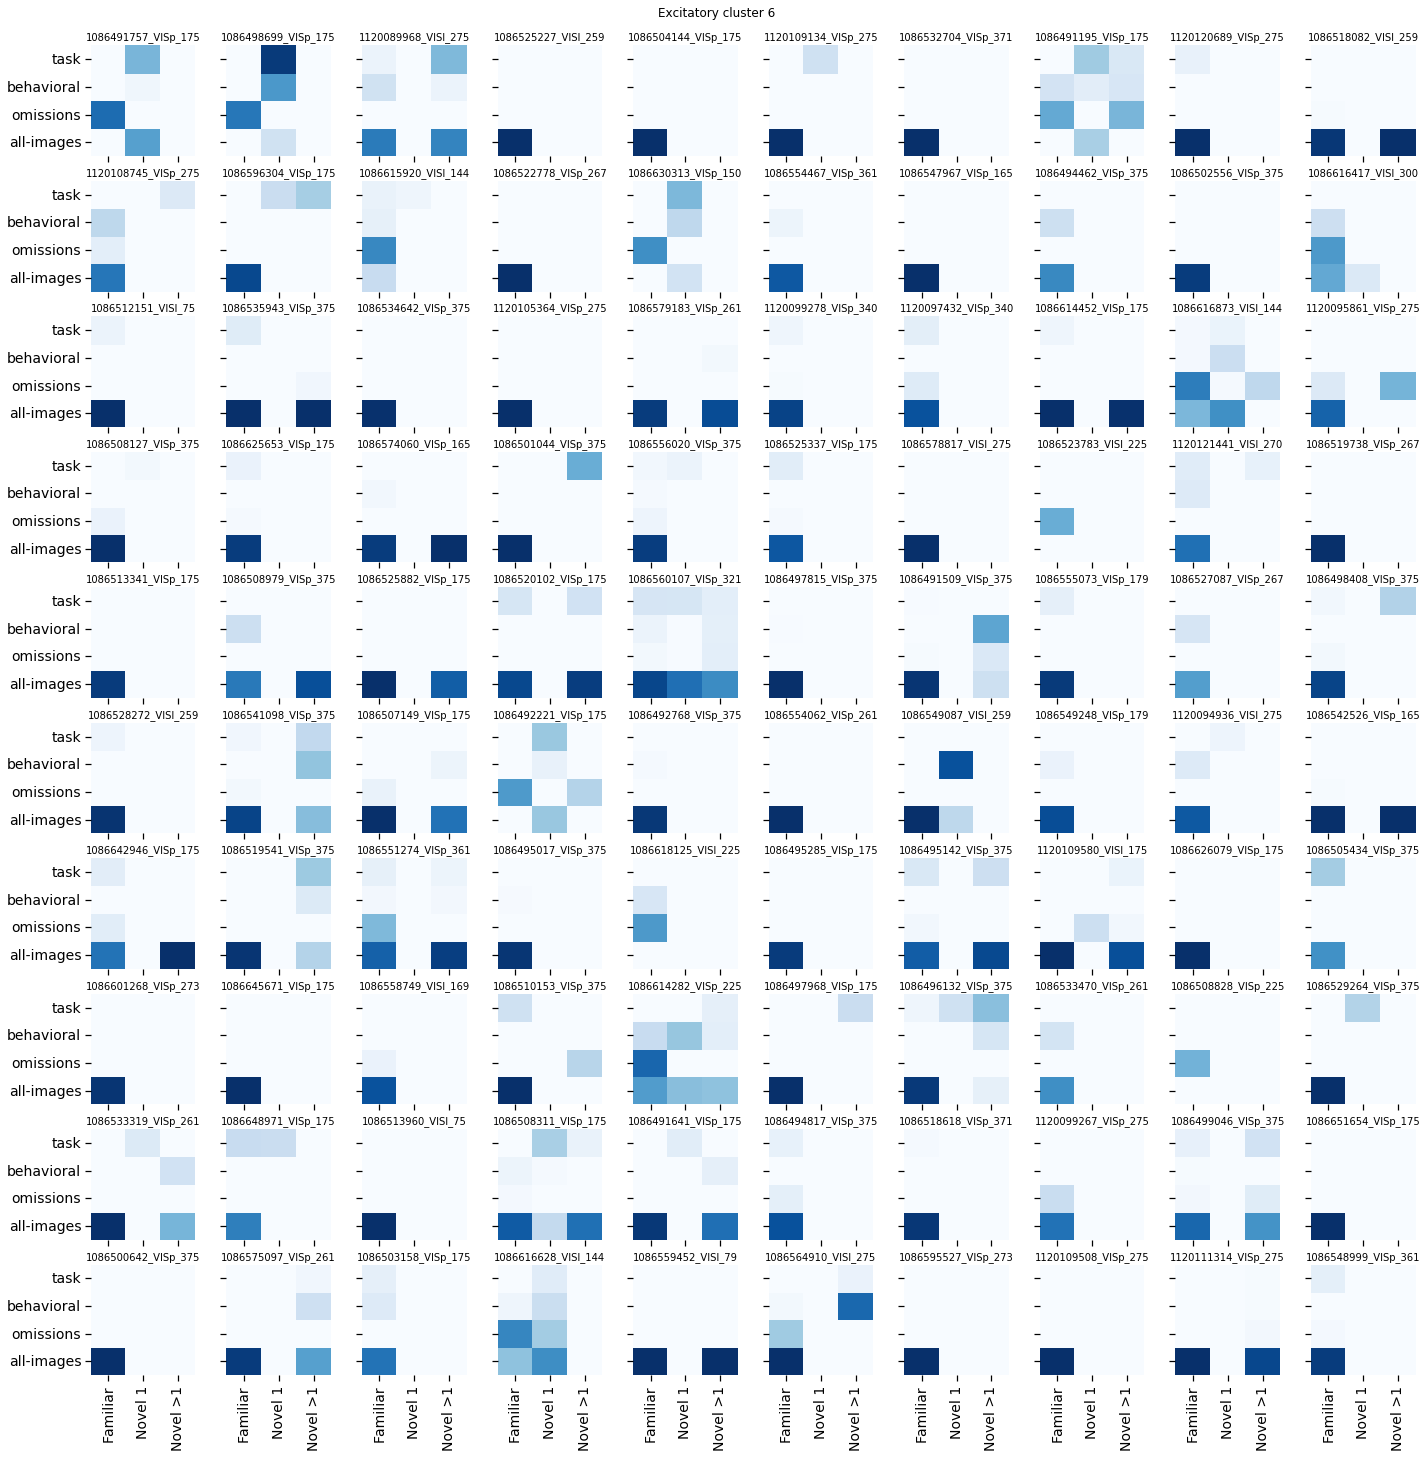

In [619]:
for cre_line in cre_lines:
    cluster_data = cluster_meta[cluster_meta.cre_line==cre_line]
    # cluster_data = cluster_data.sort_values(by=['targeted_structure', 'binned_depth'])
    cluster_labels = cluster_meta[cluster_meta.cre_line==cre_line].cluster_id.unique()


    for cluster_id in cluster_labels:

        cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].cell_specimen_id.values
        print(len(cluster_csids), 'cells in cluster', cluster_id)
        import random 
        print('selecting a random subset of 100')
        cluster_csids = random.sample(list(cluster_csids), 100)

        figsize = (20,20)
        fig, ax = plt.subplots(10,10, figsize=figsize, sharex=True, sharey=True)
        ax = ax.ravel()
        for i, cell_specimen_id in enumerate(cluster_csids[:100]):

            cell_data = cluster_meta[(cluster_meta.cluster_id==cluster_id)&
                                (cluster_meta.cell_specimen_id==cell_specimen_id)]
            cell_info = get_area_depth(cell_data.iloc[0])
            mean_dropouts = dropouts[dropouts.cell_specimen_id==cell_specimen_id].groupby('experience_level').mean()[features]
            ax[i] = sns.heatmap(mean_dropouts.T, cmap='Blues', vmin=0, vmax=1, ax=ax[i], cbar=False)#cbar_kws={'shrink':0.7, 'label':model_output_type})
            ax[i].set_title(str(cell_specimen_id)+'_'+cell_info, fontsize=10)
            ax[i].set_ylim(0,4)
            ax[i].set_yticks(np.arange(0.5, len(features)+0.5))
            ax[i].set_yticklabels(features, fontsize=14)
            ax[i].set_xlabel('')
        for i in range(90,100):
            ax[i].set_xticklabels(experience_levels, rotation=90, fontsize=14)
        fig.tight_layout()
        fig.suptitle(cell_types[cre_line]+' cluster '+str(cluster_id), x=0.5, y=1.01)
        filename = cre_line+'_cluster_'+str(cluster_id)
        utils.save_figure(fig, figsize, os.path.join(save_dir, folder), 'dropout_heatmaps_per_cluster', filename+'_1')

### breakdown by area and depth

We are going to normalize within each area or depth to account for the large imbalance in N due to Scientifica datasets only being performed in V1 at certain depths, as well as biological variation in cell type specific expression by depth

In [352]:
def make_frequency_table(cluster_meta, groupby_columns = ['binned_depth'], normalize=True):
    '''
    Computes normalized frequency for depth and area analysis in clustering
    Input:
    cluster_meta: pd.DataFrame should include columns ['cluster_id', 'cell_specimen_id', *groupby_columns*]
    groupby_columns: array, includes one or more columns to be used in groupby method
    
    Returns:
    frequency_table: pd.Dataframe, 

    '''
    
    stats_df = cluster_meta[['cluster_id', *groupby_columns]]
    frequency_table= stats_df.groupby(groupby_columns)['cluster_id'].value_counts(normalize=normalize).unstack()
    frequency_table= frequency_table.fillna(0)
    
    return frequency_table

In [318]:
cluster_meta = cluster_ids[['cell_specimen_id', 'cluster_id', 'labels']].merge(df_meta, on='cell_specimen_id')

### plot fraction cells by area and depth

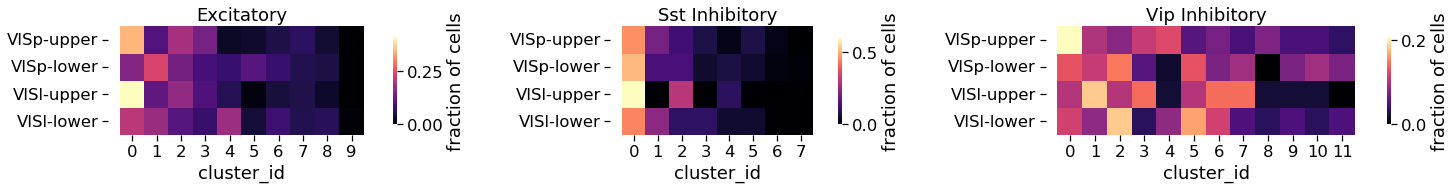

In [456]:
cre_line = cre_lines[1]

figsize = (24,2)
fig, ax = plt.subplots(1,3, figsize=figsize, gridspec_kw={'width_ratios':n_clusters_cre})

for i, cre_line in enumerate(cre_lines):
    cre_meta = cluster_meta[cluster_meta.cre_line==cre_line]
    frequency = make_frequency_table(cre_meta, groupby_columns = ['targeted_structure', 'layer'], normalize=True)

    ax[i] = sns.heatmap(frequency, vmin=0, cmap='magma', ax=ax[i], cbar_kws={'shrink':0.8, 'label':'fraction of cells'})
    ax[i].set_ylim((0, 4))
    # ax.set_yticklabels(frequency.index, rotation=0, horizontalalignment='center')
    ax[i].set_xlim(-0.5, len(frequency.columns)+0.5)
    ax[i].set_ylabel('')
    ax[i].set_title(cell_types[cre_line])
plt.subplots_adjust(wspace=0.5)
utils.save_figure(fig, figsize, base_dir, folder, 'fraction_cells_by_area_layer')

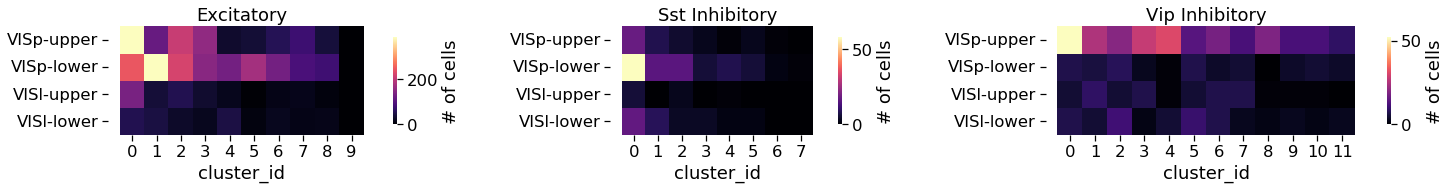

In [457]:
cre_line = cre_lines[1]

figsize = (24,2)
fig, ax = plt.subplots(1,3, figsize=figsize, gridspec_kw={'width_ratios':n_clusters_cre})

for i, cre_line in enumerate(cre_lines):
    cre_meta = cluster_meta[cluster_meta.cre_line==cre_line]
    frequency = make_frequency_table(cre_meta, groupby_columns = ['targeted_structure', 'layer'], normalize=False)

    ax[i] = sns.heatmap(frequency, vmin=0, cmap='magma', ax=ax[i], cbar_kws={'shrink':0.8, 'label':'# of cells'})
    ax[i].set_ylim((0, 4))
    # ax.set_yticklabels(frequency.index, rotation=0, horizontalalignment='center')
    ax[i].set_xlim(-0.5, len(frequency.columns)+0.5)
    ax[i].set_ylabel('')
    ax[i].set_title(cell_types[cre_line])
plt.subplots_adjust(wspace=0.5)
utils.save_figure(fig, figsize, base_dir, folder, 'n_cells_by_area_layer')

## Compute selectivity metrics on dropout scores

#### example cell dropouts

In [766]:
dropouts = rspm.merge(cells_table[['cell_specimen_id', 'cre_line', 'binned_depth', 'targeted_structure', 'layer']], on='cell_specimen_id')

In [767]:
cell_dropouts = dropouts[dropouts.cell_specimen_id==cell_specimen_id].groupby('experience_level').mean()[features]

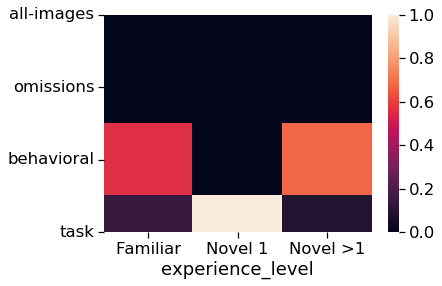

In [768]:
sns.heatmap(cell_dropouts.T)

### define stats

In [915]:
def get_coding_metrics(index_dropouts, index_value, index_name):
    """
    index_dropouts can be the dropout scores for a single cell, or average dropouts across cells
    index_dropouts should be in the format of rows = experience levels, cols = regressors
    index_value should be the cluster_id or cell_specimen_id corresponding to the input dropouts
    index_name is the column name corresponding to index_value, i.e. 'cluster_id' or 'cell_specimen_id'
    """
    stats = pd.DataFrame(index=[index_value])
    stats.index.name = index_name
    # get dropout scores per cell 
    # get preferred regressor and experience level and save
    dominant_feature = index_dropouts.stack().idxmax()[1]
    dominant_experience_level = index_dropouts.stack().idxmax()[0]
    stats.loc[index_value, 'dominant_feature'] = dominant_feature
    stats.loc[index_value, 'dominant_experience_level'] = dominant_experience_level
    # get selectivity for feature & experience level 
    # feature selectivity is ratio of largest dropout vs mean of all other dropous for the dominant experience level
    order = np.argsort(index_dropouts.loc[dominant_experience_level])
    values = index_dropouts.loc[dominant_experience_level].values[order[::-1]]
    feature_selectivity = (values[0]-(np.mean(values[1:])))/(values[0]+(np.mean(values[1:])))
    # experience selectivity is ratio of largest and average of all other dropouts for the dominant feature
    order = np.argsort(index_dropouts[dominant_feature])
    values = index_dropouts[dominant_feature].values[order[::-1]]
    experience_selectivity = (values[0]-(np.mean(values[1:])))/(values[0]+(np.mean(values[1:])))
    stats.loc[index_value, 'feature_selectivity'] = feature_selectivity
    stats.loc[index_value, 'experience_selectivity'] = experience_selectivity
    # get experience modulation indices
    row = index_dropouts[dominant_feature]
    # direction of exp mod is whether coding is stronger for familiar or novel
    exp_mod_direction = (row['Novel 1']-row['Familiar'])/(row['Novel 1']+row['Familiar'])
    # persistence of exp mod is whether coding stays similar after repetition of novel session
    exp_mod_persistence = (row['Novel >1']-row['Novel 1'])/(row['Novel >1']+row['Novel 1'])
    stats.loc[index_value, 'exp_mod_direction'] = exp_mod_direction
    stats.loc[index_value, 'exp_mod_persistence'] = exp_mod_persistence
    # within session joint coding index
    # get order and values of features for pref exp level
    order = np.argsort(index_dropouts.loc[dominant_experience_level])
    values = index_dropouts.loc[dominant_experience_level].values[order[::-1]]
#     # joint coding index is first highest feature dropout relative to mean of all other features 
#     feature_sel_within_session = (values[0]-(np.mean(values[1:])))/(values[0]+(np.mean(values[1:])))
    # joint coding index is first highest feature dropout relative to next highest
    feature_sel_within_session = (values[0]-values[1])/(values[0]+values[1])
    # get across session switching index - ratio of pref exp & feature to next max exp & feature, excluding within session or feature comparisons
    # get the max value 
    pref_cond_value = index_dropouts.loc[dominant_experience_level][dominant_feature]
    # get the remaining columns after removing the max exp level and feature
    non_pref_conditions = index_dropouts.drop(index=dominant_experience_level).drop(columns=dominant_feature)
    # get the exp level and feature with the next highest value 
    next_highest_conditions = non_pref_conditions.stack().idxmax()
    stats.insert(loc=2, column='next_highest_conditions', value=[next_highest_conditions])
    next_experience_level = next_highest_conditions[0]
    next_feature = next_highest_conditions[1]
    next_highest_value = index_dropouts.loc[next_experience_level][next_feature]
    # switching index is ratio of max condition to next max (excluding within session & feature comparisons)
    feature_sel_across_sessions = (pref_cond_value-next_highest_value)/(pref_cond_value+next_highest_value)
    stats.loc[index_value, 'feature_sel_within_session'] = feature_sel_within_session
    stats.loc[index_value, 'feature_sel_across_sessions'] = feature_sel_across_sessions
    return stats

### check that everything makes sense for example cell 

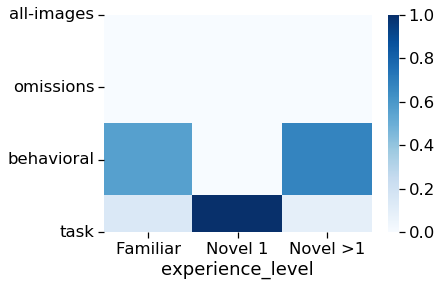

In [916]:
example_cell = 1086548999
cell_dropouts = dropouts[dropouts.cell_specimen_id==cell_specimen_id].groupby('experience_level').mean()[features]
sns.heatmap(cell_dropouts.T, cmap='Blues')

In [917]:
stats = get_coding_metrics(index_dropouts=cell_dropouts, index_value=cell_specimen_id, index_name='cell_specimen_id')
stats

dominant_feature dominant_experience_level  \
cell_specimen_id                                              
1086673591                   task                   Novel 1   

                 next_highest_conditions  feature_selectivity  \
cell_specimen_id                                                
1086673591        (Novel >1, behavioral)                  1.0   

                  experience_selectivity  exp_mod_direction  \
cell_specimen_id                                              
1086673591                      0.788599           0.747191   

                  exp_mod_persistence  feature_sel_within_session  \
cell_specimen_id                                                    
1086673591                  -0.832017                         1.0   

                  feature_sel_across_sessions  
cell_specimen_id                               
1086673591                           0.192364

* positive value of exp_mod_direction means stronger coding of pref feature in novel session 
* positive value of exp_mod_persistence means similar coding in Novel 1 and Novel >1 for pref feature
* high value of feature_sel_within_session means highly feature selective in strongest exp level
* low value of feature_sel_within_session means similar strength of coding for multiple features in a given session
* high value of feature_sel_across sessions means there is a big difference between the strength of coding for the preferred feature in the preferred experience level and a different feature in a different experience level 
* low value of feature_sel_across sessions means similar coding across two different features in two different sessions
* cell switching is indicated by low feature_sel_across_sessions and high experience selectivity
* lack of coding overall would be low exp selectivity and low feature_sel_across_sessions

### compute stats across cells 

In [918]:
cell_stats = pd.DataFrame()
for i, cell_specimen_id in enumerate(cluster_meta.cell_specimen_id.values):
    cell_dropouts = dropouts[dropouts.cell_specimen_id==cell_specimen_id].groupby('experience_level').mean()[features]
    stats = get_coding_metrics(index_dropouts=cell_dropouts, index_value=cell_specimen_id, index_name='cell_specimen_id')
    cell_stats = pd.concat([cell_stats, stats], sort=False)
cell_stats = cell_stats.merge(cluster_meta, on='cell_specimen_id')
metrics = stats.keys()[-6:]

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


### plot experience mod across all cells 

10
8
10


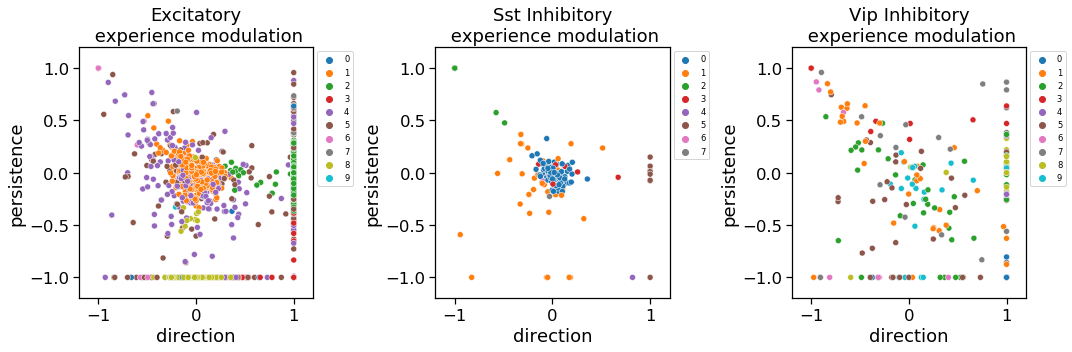

In [919]:
figsize = (15,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = cell_stats[cell_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    print(n_clusters)
    ax[i] = sns.scatterplot(data=data, x='exp_mod_direction', y='exp_mod_persistence', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], ax=ax[i])
    ax[i].set_title(cell_types[cre_line]+'\n experience modulation')
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('direction')
    ax[i].set_ylabel('persistence')
    ax[i].set_xlim(-1.2,1.2)
    ax[i].set_ylim(-1.2,1.2)
fig.tight_layout()
utils.save_figure(fig, figsize, base_dir, folder, 'experience_modulation_across_cells')

### feature selectivity across cells 

In [920]:
cell_stats.keys()

Index(['cell_specimen_id', 'dominant_feature', 'dominant_experience_level',
       'next_highest_conditions', 'feature_selectivity',
       'experience_selectivity', 'exp_mod_direction', 'exp_mod_persistence',
       'feature_sel_within_session', 'feature_sel_across_sessions',
       'cluster_id', 'labels', 'ophys_experiment_id', 'equipment_name',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'ophys_session_id',
       'behavior_session_id', 'ophys_container_id', 'project_code',
       'imaging_depth', 'targeted_structure', 'date_of_acquisition',
       'session_type', 'experience_level', 'passive', 'image_set', 'file_id',
       'cell_type', 'depth', 'binned_depth', 'area_depth', 'area_binned_depth',
       'layer', 'date', 'first_novel', 'n_relative_to_first_novel',
       'last_f

### get average metric values per cluster

In [921]:
avg_cluster_stats = cell_stats.groupby(['cre_line', 'cluster_id']).mean()
avg_cluster_stats = avg_cluster_stats[list(metrics)]
avg_cluster_stats = avg_cluster_stats.reset_index()
n_cells = cell_stats.groupby(['cre_line', 'cluster_id']).count()[['labels']].rename(columns={'labels':'n_cells'})
avg_cluster_stats = avg_cluster_stats.merge(n_cells, on=['cre_line', 'cluster_id'])

10
8
10


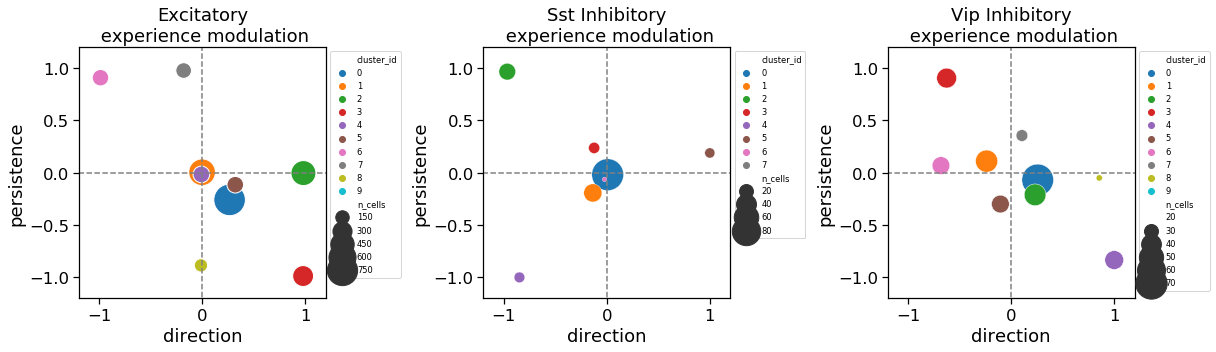

In [922]:
figsize = (17,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    print(n_clusters)
    ax[i] = sns.scatterplot(data=data, x='exp_mod_direction', y='exp_mod_persistence', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i])
    ax[i].axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
    ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line]+'\n experience modulation')
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('direction')
    ax[i].set_ylabel('persistence')
    ax[i].set_xlim(-1.2,1.2)
    ax[i].set_ylim(-1.2,1.2)
fig.tight_layout()
utils.save_figure(fig, figsize, base_dir, folder, 'experience_modulation_avg_across_cells_in_cluster')

### cells and clusters together 

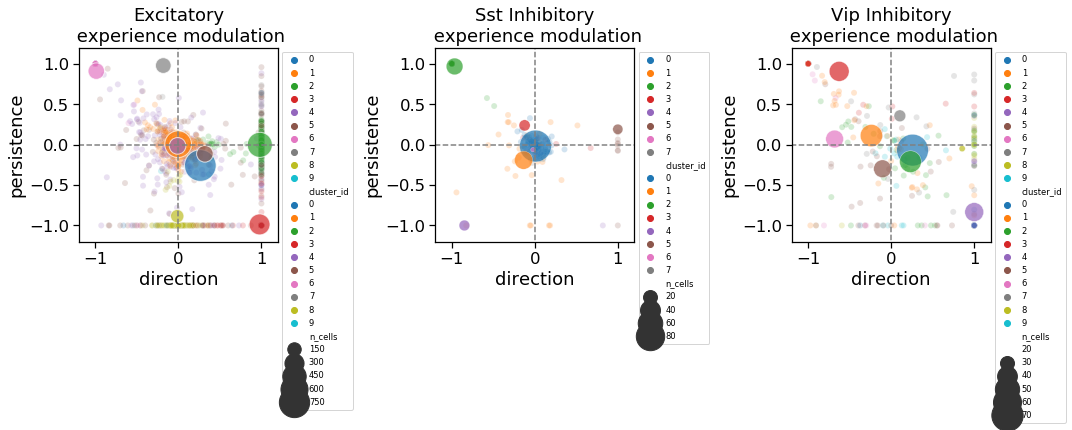

In [923]:
figsize = (15,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = cell_stats[cell_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    ax[i] = sns.scatterplot(data=data, x='exp_mod_direction', y='exp_mod_persistence', alpha=0.2,
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], ax=ax[i])
    
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    ax[i] = sns.scatterplot(data=data, x='exp_mod_direction', y='exp_mod_persistence', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i], alpha=0.7)
    
    ax[i].axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
    ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line]+'\n experience modulation')
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('direction')
    ax[i].set_ylabel('persistence')
    ax[i].set_xlim(-1.2,1.2)
    ax[i].set_ylim(-1.2,1.2)
fig.tight_layout()
utils.save_figure(fig, figsize, base_dir, folder, 'experience_modulation_across_cells_and_clusters')

### plot clusters with exp mod metric values

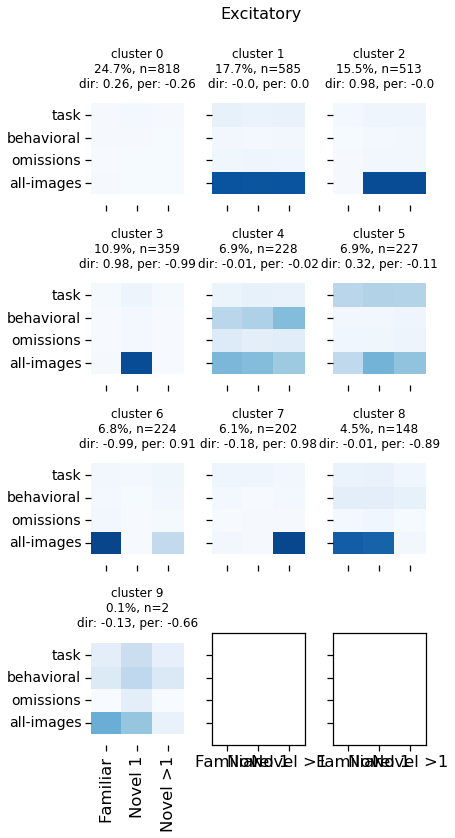

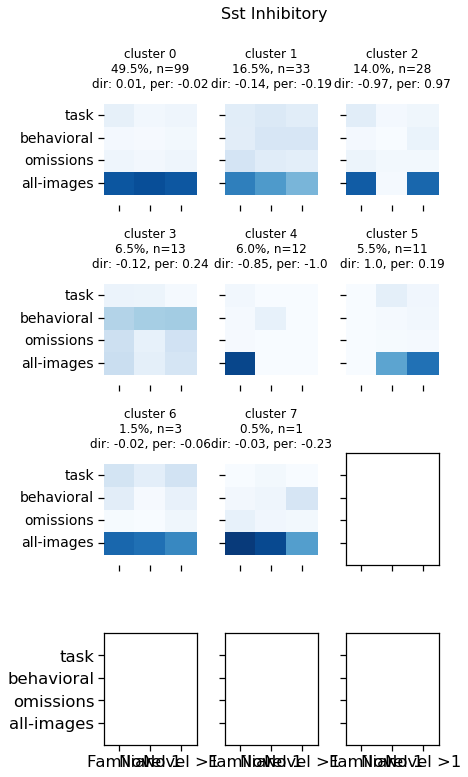

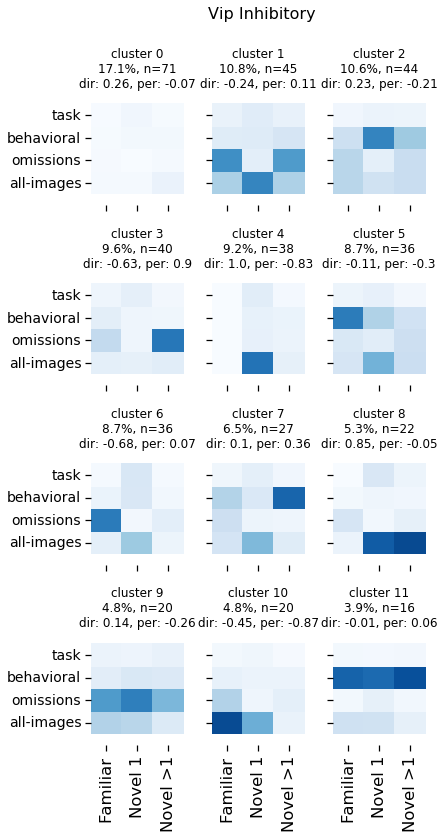

In [924]:
for cre_line in cre_lines:
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    # get cell specimen ids for this cre line
    cre_cell_specimen_ids = df_meta[df_meta.cre_line==cre_line].index.values
    # get cluster labels dataframe for this cre line
    cre_cluster_ids = cluster_ids[cluster_ids.cell_specimen_id.isin(cre_cell_specimen_ids)]
    # get unique cluster labels for this cre line
    cluster_labels = np.sort(cre_cluster_ids.cluster_id.unique())
    n_clusters = len(cluster_labels)

    figsize = (6,12)
    fig, ax = plt.subplots(4, 3, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    # limit dropouts df to cells in this cre line
    df_cre = df.loc[cre_cell_specimen_ids]
    for i, cluster_id in enumerate(cluster_labels):
        # get cell specimen ids in this cluster in this cre line
        this_cluster_csids = cre_cluster_ids[cre_cluster_ids['cluster_id'] == cluster_id].cell_specimen_id.values
        # get dropout scores for cells in this cluster in this cre line
        mean_dropout_df = np.abs(df_cre.loc[this_cluster_csids].mean().unstack())
        ax[i] = sns.heatmap(mean_dropout_df, cmap='Blues', vmin=0, vmax=1, ax=ax[i], cbar=False)
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cre = len(this_cluster_csids) / float(len(cre_cell_specimen_ids))
        fraction = np.round(fraction_cre * 100, 1)
        direction = np.round(data[data.cluster_id==cluster_id].exp_mod_direction.values[0],2)
        persistence = np.round(data[data.cluster_id==cluster_id].exp_mod_persistence.values[0],2 )
        title = 'cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids))
        title = title+'\ndir: '+str(direction)+', per: '+str(persistence)
        # set title and labels
        ax[i].set_title(title, fontsize=12)
        ax[i].set_yticklabels(mean_dropout_df.index.values, rotation=0, fontsize=14)
        ax[i].set_ylim(-0.5, 4.5)
        ax[i].set_xlabel('')
    # fig.tight_layout()
    plt.suptitle(cell_types[cre_line], x=0.52, y=.98, fontsize=16)
    plt.subplots_adjust(hspace=0.6, wspace=0.3)
    utils.save_figure(fig, figsize, base_dir, folder, 'cluster_heatmaps_exp_mod_metrics_avg_of_cells_in_cluster_'+cre_line)

### feature selectivity within and across sesions

10
8
10


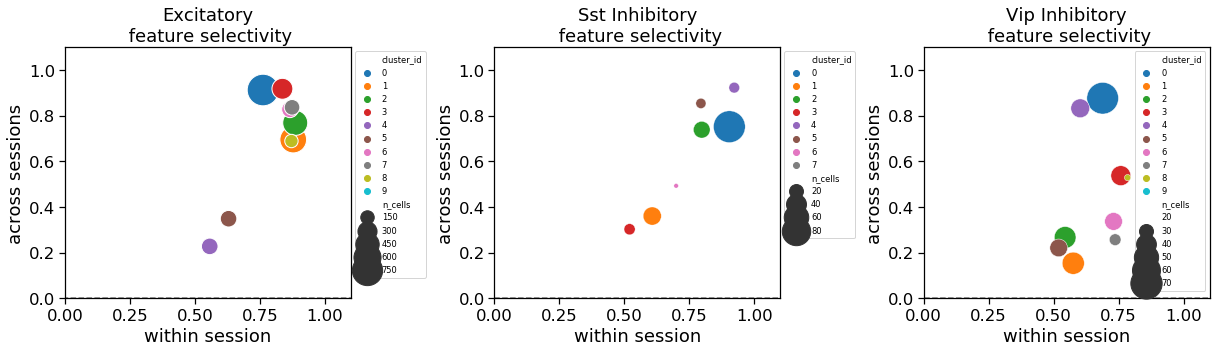

In [925]:
figsize = (17,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    print(n_clusters)
    ax[i] = sns.scatterplot(data=data, x='feature_sel_within_session', y='feature_sel_across_sessions', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i])
    ax[i].axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
    ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line]+'\n feature selectivity')
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('within session')
    ax[i].set_ylabel('across sessions')
    ax[i].set_xlim(0, 1.1)
    ax[i].set_ylim(0, 1.1)
fig.tight_layout()
utils.save_figure(fig, figsize, base_dir, folder, 'feature_selectivity_avg_across_cells_in_cluster')

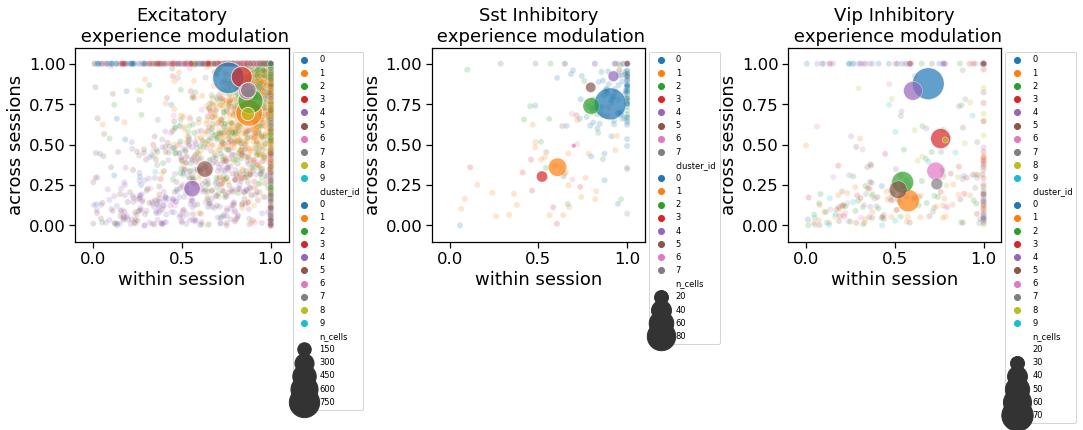

In [926]:
figsize = (15,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = cell_stats[cell_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    ax[i] = sns.scatterplot(data=data, x='feature_sel_within_session', y='feature_sel_across_sessions', alpha=0.2,
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], ax=ax[i])
    
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    ax[i] = sns.scatterplot(data=data, x='feature_sel_within_session', y='feature_sel_across_sessions', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i], alpha=0.7)
    
#     ax[i].axvline(x=0, ymin=0, ymax=1, linestyle='--', color='gray')
#     ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line]+'\n experience modulation')
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('within session')
    ax[i].set_ylabel('across sessions')
    ax[i].set_xlim(-0.1,1.1)
    ax[i].set_ylim(-0.1,1.1)
fig.tight_layout()
utils.save_figure(fig, figsize, base_dir, folder, 'feature_selectivity_across_cells_and_clusters')

### feature selectivity across sessions vs. experience selectivity 

* cell switching is indicated by low feature_sel_across_sessions and high experience selectivity


In [927]:
avg_cluster_stats.keys()

Index(['cre_line', 'cluster_id', 'feature_selectivity',
       'experience_selectivity', 'exp_mod_direction', 'exp_mod_persistence',
       'feature_sel_within_session', 'feature_sel_across_sessions', 'n_cells'],
      dtype='object')

10
8
10


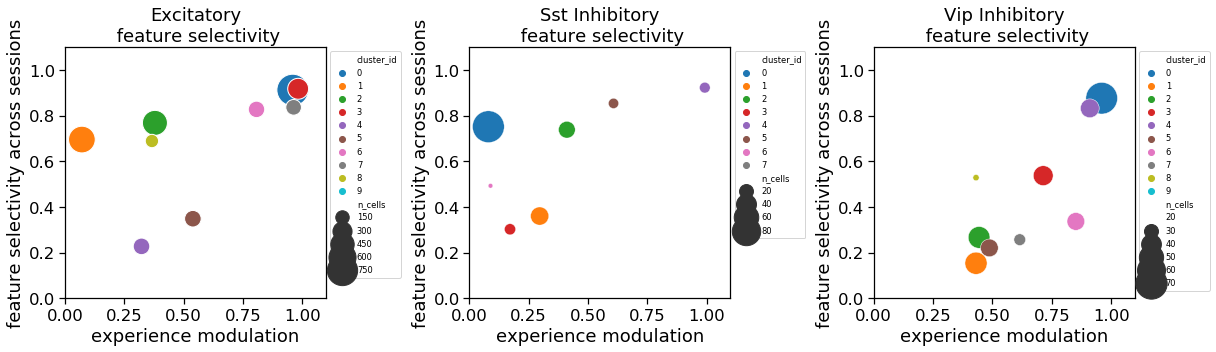

In [928]:
figsize = (17,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    print(n_clusters)
    ax[i] = sns.scatterplot(data=data, x='experience_selectivity', y='feature_sel_across_sessions', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i])
#     ax[i].axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
#     ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line]+'\n feature selectivity')
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('experience modulation')
    ax[i].set_ylabel('feature selectivity across sessions')
    ax[i].set_xlim(0, 1.1)
    ax[i].set_ylim(0, 1.1)
fig.tight_layout()
utils.save_figure(fig, figsize, base_dir, folder, 'feature_sel_exp_mod_avg_across_cells_in_cluster')

### cluster plots with feature selectivity metrics 

In [911]:
data.keys()

Index(['cre_line', 'cluster_id', 'feature_selectivity',
       'experience_selectivity', 'exp_mod_direction', 'exp_mod_persistence',
       'feature_sel_within_session', 'feature_sel_across_sessions', 'n_cells'],
      dtype='object')

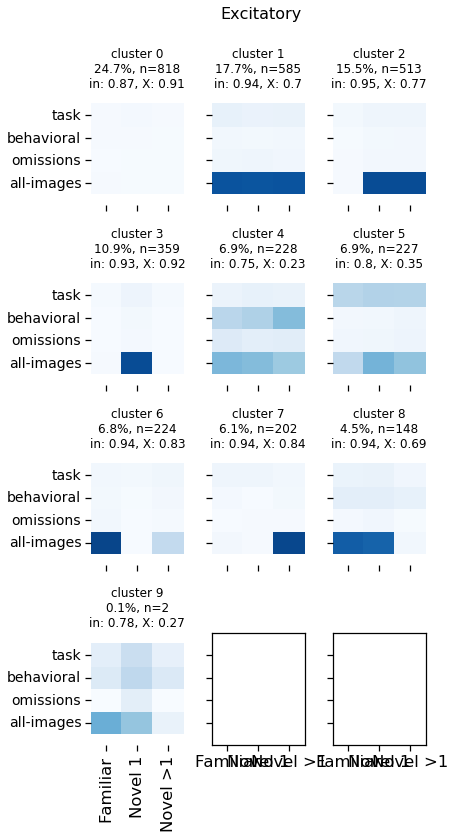

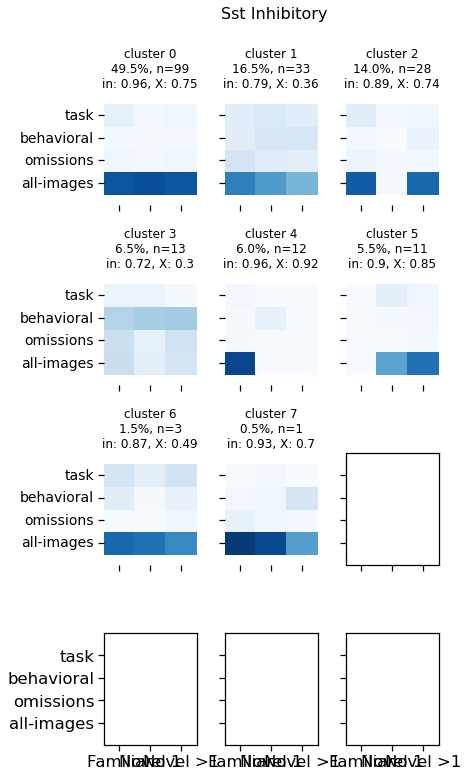

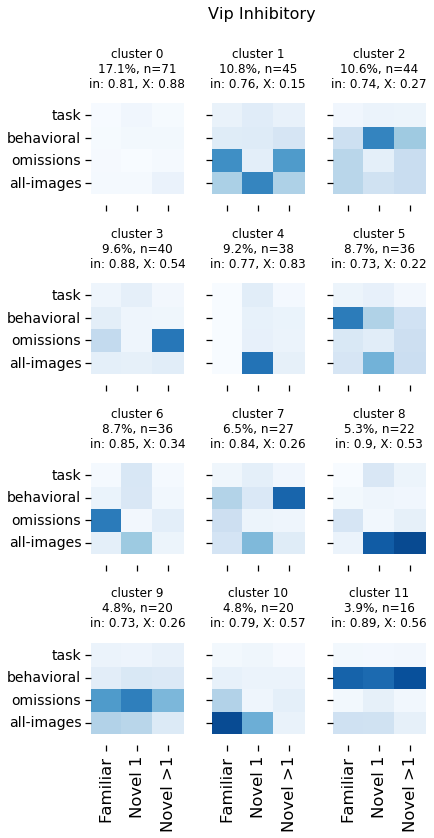

In [914]:
for cre_line in cre_lines:
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    # get cell specimen ids for this cre line
    cre_cell_specimen_ids = df_meta[df_meta.cre_line==cre_line].index.values
    # get cluster labels dataframe for this cre line
    cre_cluster_ids = cluster_ids[cluster_ids.cell_specimen_id.isin(cre_cell_specimen_ids)]
    # get unique cluster labels for this cre line
    cluster_labels = np.sort(cre_cluster_ids.cluster_id.unique())
    n_clusters = len(cluster_labels)

    figsize = (6,12)
    fig, ax = plt.subplots(4, 3, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    # limit dropouts df to cells in this cre line
    df_cre = df.loc[cre_cell_specimen_ids]
    for i, cluster_id in enumerate(cluster_labels):
        # get cell specimen ids in this cluster in this cre line
        this_cluster_csids = cre_cluster_ids[cre_cluster_ids['cluster_id'] == cluster_id].cell_specimen_id.values
        # get dropout scores for cells in this cluster in this cre line
        mean_dropout_df = np.abs(df_cre.loc[this_cluster_csids].mean().unstack())
        ax[i] = sns.heatmap(mean_dropout_df, cmap='Blues', vmin=0, vmax=1, ax=ax[i], cbar=False)
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cre = len(this_cluster_csids) / float(len(cre_cell_specimen_ids))
        fraction = np.round(fraction_cre * 100, 1)
        within = np.round(data[data.cluster_id==cluster_id].feature_sel_within_session.values[0],2)
        across = np.round(data[data.cluster_id==cluster_id].feature_sel_across_sessions.values[0],2 )
        title = 'cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids))
        title = title+'\nin: '+str(within)+', X: '+str(across)
        # set title and labels
        ax[i].set_title(title, fontsize=12)
        ax[i].set_yticklabels(mean_dropout_df.index.values, rotation=0, fontsize=14)
        ax[i].set_ylim(-0.5, 4.5)
        ax[i].set_xlabel('')
    # fig.tight_layout()
    plt.suptitle(cell_types[cre_line], x=0.52, y=.98, fontsize=16)
    plt.subplots_adjust(hspace=0.6, wspace=0.3)
    utils.save_figure(fig, figsize, base_dir, folder, 'cluster_heatmaps_feature_sel_metrics_avg_of_cells_in_cluster_'+cre_line)

### compute stats on cluster heatmaps directly 

In [873]:
cluster_stats = pd.DataFrame()
for cre_line in cre_lines:
    # get cell specimen ids for this cre line
    cre_cell_specimen_ids = df_meta[df_meta.cre_line==cre_line].index.values
    # get cluster labels dataframe for this cre line
    cre_cluster_ids = cluster_ids[cluster_ids.cell_specimen_id.isin(cre_cell_specimen_ids)]
    # get unique cluster labels for this cre line
    cluster_labels = np.sort(cre_cluster_ids.cluster_id.unique())
    # limit dropouts df to cells in this cre line
    df_cre = df.loc[cre_cell_specimen_ids]
    for i, cluster_id in enumerate(cluster_labels):
        # get cell specimen ids in this cluster in this cre line
        this_cluster_csids = cre_cluster_ids[cre_cluster_ids['cluster_id'] == cluster_id].cell_specimen_id.values
        # get dropout scores for cells in this cluster in this cre line
        mean_dropout_df = np.abs(df_cre.loc[this_cluster_csids].mean().unstack())
        stats = get_coding_metrics(index_dropouts=mean_dropout_df.T, index_value=cluster_id, index_name='cluster_id')
        stats['cre_line'] = cre_line
        cluster_stats = pd.concat([cluster_stats, stats])
cluster_stats = cluster_stats.reset_index()
n_cells = cell_stats.groupby(['cre_line', 'cluster_id']).count()[['labels']].rename(columns={'labels':'n_cells'})
cluster_stats = cluster_stats.merge(n_cells, on=['cre_line', 'cluster_id'])

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


10
8
10


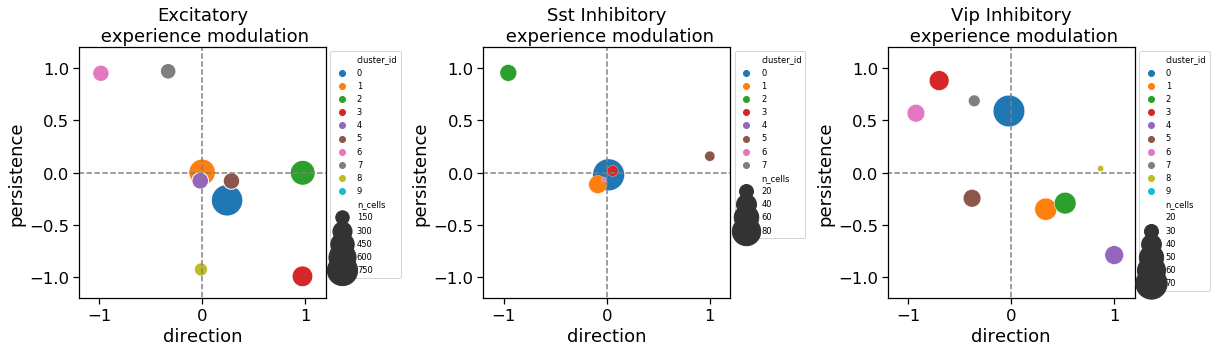

In [880]:
figsize = (17,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = cluster_stats[cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    print(n_clusters)
    ax[i] = sns.scatterplot(data=data, x='exp_mod_direction', y='exp_mod_persistence', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i])
    ax[i].axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
    ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line]+'\n experience modulation')
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('direction')
    ax[i].set_ylabel('persistence')
    ax[i].set_xlim(-1.2,1.2)
    ax[i].set_ylim(-1.2,1.2)
fig.tight_layout()
utils.save_figure(fig, figsize, base_dir, folder, 'experience_modulation_across_clusters')

### plot each cluster with metrics in title

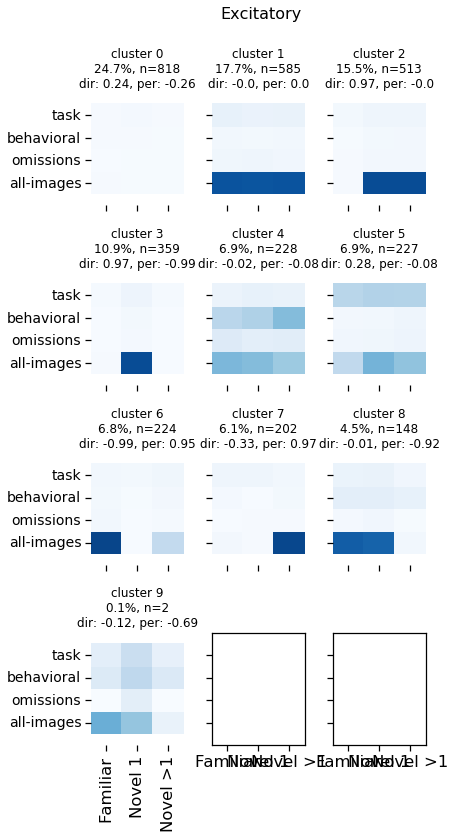

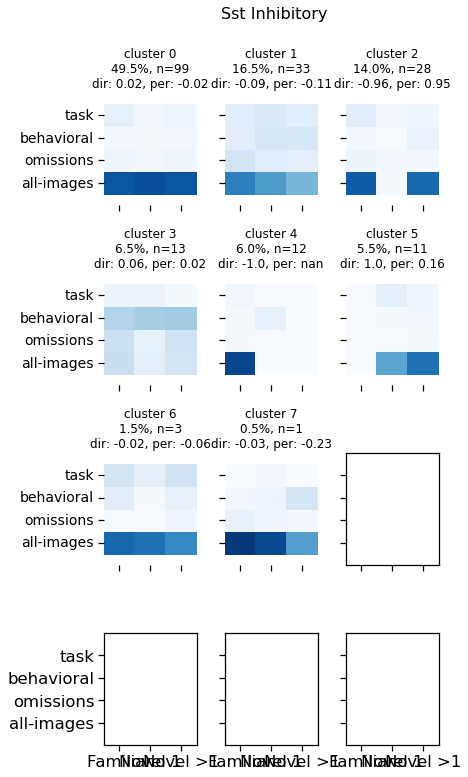

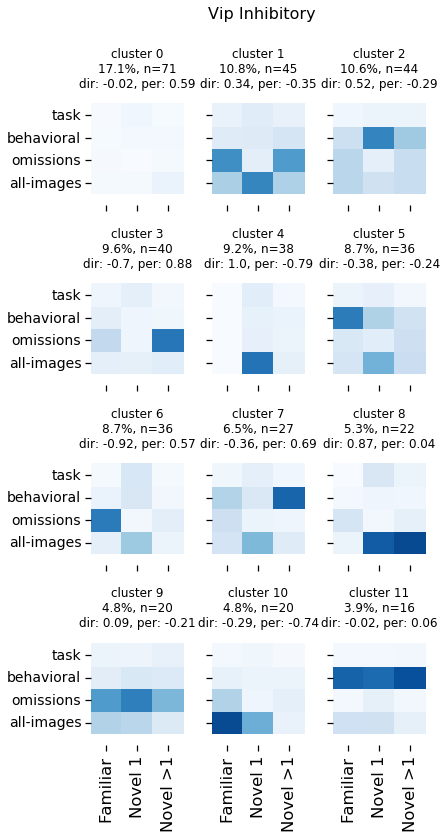

In [881]:
for cre_line in cre_lines:
    data = cluster_stats[cluster_stats.cre_line==cre_line]
    # get cell specimen ids for this cre line
    cre_cell_specimen_ids = df_meta[df_meta.cre_line==cre_line].index.values
    # get cluster labels dataframe for this cre line
    cre_cluster_ids = cluster_ids[cluster_ids.cell_specimen_id.isin(cre_cell_specimen_ids)]
    # get unique cluster labels for this cre line
    cluster_labels = np.sort(cre_cluster_ids.cluster_id.unique())
    n_clusters = len(cluster_labels)

    figsize = (6,12)
    fig, ax = plt.subplots(4, 3, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    # limit dropouts df to cells in this cre line
    df_cre = df.loc[cre_cell_specimen_ids]
    for i, cluster_id in enumerate(cluster_labels):
        # get cell specimen ids in this cluster in this cre line
        this_cluster_csids = cre_cluster_ids[cre_cluster_ids['cluster_id'] == cluster_id].cell_specimen_id.values
        # get dropout scores for cells in this cluster in this cre line
        mean_dropout_df = np.abs(df_cre.loc[this_cluster_csids].mean().unstack())
        ax[i] = sns.heatmap(mean_dropout_df, cmap='Blues', vmin=0, vmax=1, ax=ax[i], cbar=False)
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cre = len(this_cluster_csids) / float(len(cre_cell_specimen_ids))
        fraction = np.round(fraction_cre * 100, 1)
        direction = np.round(data[data.cluster_id==cluster_id].exp_mod_direction.values[0],2)
        persistence = np.round(data[data.cluster_id==cluster_id].exp_mod_persistence.values[0],2 )
        title = 'cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids))
        title = title+'\ndir: '+str(direction)+', per: '+str(persistence)
        # set title and labels
        ax[i].set_title(title, fontsize=12)
        ax[i].set_yticklabels(mean_dropout_df.index.values, rotation=0, fontsize=14)
        ax[i].set_ylim(-0.5, 4.5)
        ax[i].set_xlabel('')
    # fig.tight_layout()
    plt.suptitle(cell_types[cre_line], x=0.52, y=.98, fontsize=16)
    plt.subplots_adjust(hspace=0.6, wspace=0.3)
    utils.save_figure(fig, figsize, base_dir, folder, 'cluster_heatmaps_exp_mod_metrics_'+cre_line)

### summarize

In [597]:
n_clusters_per_cre = cell_stats.groupby(['cre_line']).count().rename(columns={'cluster_id':'n_cells_total'})[['n_cells_total']]
n_clusters_per_feature = cell_stats.groupby(['cre_line', 'dominant_feature']).count().rename(columns={'cluster_id':'n_cells'})[['n_cells']]
n_clusters_per_feature = n_clusters_per_feature.reset_index().merge(n_clusters_per_cre, on='cre_line')
n_clusters_per_feature['fraction_cells'] = n_clusters_per_feature['n_cells']/n_clusters_per_feature['n_cells_total']

[Text(0, 0, 'all-images'),
 Text(0, 0, 'omissions'),
 Text(0, 0, 'behavioral'),
 Text(0, 0, 'task')]

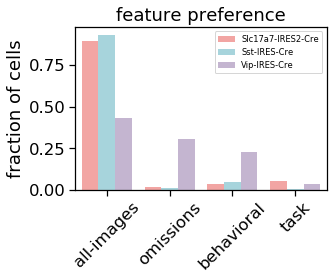

In [604]:
colors = utils.get_cre_line_colors()

figsize=(4.5,3)
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=n_clusters_per_feature, x='dominant_feature', y='fraction_cells', hue='cre_line',
             palette=colors, order=features, hue_order=cre_lines, ax=ax)
ax.legend(fontsize='small', title='', loc='upper right')
ax.set_ylabel('fraction of cells')
ax.set_xlabel('')
ax.set_title('feature preference')
ax.set_xticklabels(features, rotation=45)

In [609]:
n_clusters_per_cre = cell_stats.groupby(['cre_line']).count().rename(columns={'cluster_id':'n_cells_total'})[['n_cells_total']]
n_clusters_per_feature = cell_stats.groupby(['cre_line', 'dominant_experience_level']).count().rename(columns={'cluster_id':'n_cells'})[['n_cells']]
n_clusters_per_feature = n_clusters_per_feature.reset_index().merge(n_clusters_per_cre, on='cre_line')
n_clusters_per_feature['fraction_cells'] = n_clusters_per_feature['n_cells']/n_clusters_per_feature['n_cells_total']

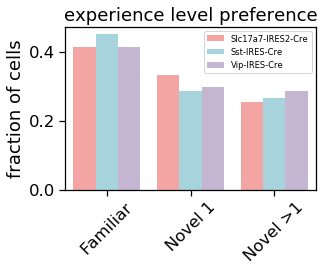

In [614]:
colors = utils.get_cre_line_colors()

figsize=(4.5,3)
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=n_clusters_per_feature, x='dominant_experience_level', y='fraction_cells', hue='cre_line',
             palette=colors, order=experience_levels, hue_order=cre_lines, ax=ax)
ax.legend(fontsize='small', title='', loc='upper right')
ax.set_ylabel('fraction of cells')
ax.set_xlabel('')
ax.set_title('experience level preference')
ax.set_xticklabels(experience_levels, rotation=45);

### repeat but per cluster instead of across cells 

In [ ]:
cell_stats = cluster_meta.copy()
cell_stats = cell_stats.set_index('cell_specimen_id')
for i, cell_specimen_id in enumerate(cell_stats.index.values):
    # get dropout scores per cell 
    cell_dropouts = dropouts[dropouts.cell_specimen_id==cell_specimen_id].groupby('experience_level').mean()[features]
    # get preferred regressor and experience level and save
    dominant_feature = cell_dropouts.stack().idxmax()[1]
    dominant_experience_level = cell_dropouts.stack().idxmax()[0]
    cell_stats.loc[cell_specimen_id, 'dominant_feature'] = dominant_feature
    cell_stats.loc[cell_specimen_id, 'dominant_experience_level'] = dominant_experience_level
    # get selectivity for feature & experience level 
    # feature selectivity is ratio of largest and next largest dropouts for the dominant experience level
    order = np.argsort(cell_dropouts.loc[dominant_experience_level])
    values = cell_dropouts.loc[dominant_experience_level].values[order[::-1]]
    feature_selectivity = (values[0]-(np.mean(values[1:])))/(values[0]+(np.mean(values[1:])))
    # experience selectivity is ratio of largest and next largest dropouts for the dominant feature
    order = np.argsort(cell_dropouts[dominant_feature])
    values = cell_dropouts[dominant_feature].values[order[::-1]]
    experience_selectivity = (values[0]-(np.mean(values[1:])))/(values[0]+(np.mean(values[1:])))
    cell_stats.loc[cell_specimen_id, 'feature_selectivity'] = feature_selectivity
    cell_stats.loc[cell_specimen_id, 'experience_selectivity'] = experience_selectivity

In [ ]:
max_size = 0
max_size = 1000

figsize=(4,3)
fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(data=cluster_stats, x='cell_type', y='feature_selectivity', hue='cell_type',
             palette=colors, hue_order=cell_types, size='fraction_cells_in_cluster', sizes=(min_size, max_size), ax=ax)
ax.legend(fontsize='x-small', title='', bbox_to_anchor=(1.1,1))
ax.set_ylabel('feature selectivity index')
ax.set_xlabel('')
ax.set_title('feature selectivity')
ax.set_xticklabels(cell_types, rotation=45)

ax.set_ylim(0,1)

In [ ]:
 max_size = 0
max_size = 1000

figsize=(4,3)
fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(data=cluster_stats, x='cell_type', y='experience_selectivity', hue='cell_type',
             palette=colors, hue_order=cell_types, size='fraction_cells_in_cluster', sizes=(min_size, max_size), ax=ax)
ax.legend(fontsize='x-small', title='', bbox_to_anchor=(1.1,1))
ax.set_ylabel('experience selectivity index')
ax.set_xlabel('')
ax.set_title('experience selectivity')
ax.set_xticklabels(cell_types, rotation=45)
ax.set_ylim(0,1)

### details stuff / validation

#### count number of cells in different areas & depths

In [357]:
make_frequency_table(cluster_meta, groupby_columns = ['cre_line', 'targeted_structure'], normalize=False)

cluster_id                               0      1      2      3      4   \
cre_line          targeted_structure                                      
Slc17a7-IRES2-Cre VISl                189.0   85.0   84.0   54.0   67.0   
                  VISp                629.0  500.0  429.0  305.0  161.0   
Sst-IRES-Cre      VISl                 23.0    9.0    7.0    4.0    3.0   
                  VISp                 76.0   24.0   21.0    9.0    9.0   
Vip-IRES-Cre      VISl                 12.0   14.0   16.0    9.0    6.0   
                  VISp                 59.0   31.0   28.0   31.0   32.0   

cluster_id                               5      6      7      8     9     10  \
cre_line          targeted_structure                                           
Slc17a7-IRES2-Cre VISl                 15.0   37.0   33.0   27.0   1.0   0.0   
                  VISp                212.0  187.0  169.0  121.0   1.0   0.0   
Sst-IRES-Cre      VISl                  2.0    0.0    0.0    0.0   0.0   0.0   
                  VISp                  9.0    3.0    1.0    0.0   0.0   0.0   
Vip-IRES-Cre      VISl                 15.0   14.0   10.0    3.0   4.0   3.0   
                  VISp                 21.0   22.0   17.0   19.0  16.0  17.0   

cluster_id                              11  
cre_line          targeted_structure        
Slc17a7-IRES2-Cre VISl                 0.0  
                  VISp                 0.0  
Sst-IRES-Cre      VISl                 0.0  
                  VISp                 0.0  
Vip-IRES-Cre      VISl                 3.0  
                  VISp                13.0

There are way more cells in VISp than VISl

In [354]:
make_frequency_table(cluster_meta, groupby_columns = ['cre_line', 'layer'], normalize=False)

cluster_id                  0      1      2      3      4      5      6   \
cre_line          layer                                                    
Slc17a7-IRES2-Cre lower  300.0  429.0  250.0  170.0  176.0  185.0  151.0   
                  upper  518.0  156.0  263.0  189.0   52.0   42.0   73.0   
Sst-IRES-Cre      lower   75.0   25.0   20.0   10.0   10.0    8.0    2.0   
                  upper   24.0    8.0    8.0    3.0    2.0    3.0    1.0   
Vip-IRES-Cre      lower   14.0   11.0   19.0    5.0    6.0   17.0   11.0   
                  upper   57.0   34.0   25.0   35.0   32.0   19.0   25.0   

cluster_id                  7     8     9     10   11  
cre_line          layer                                
Slc17a7-IRES2-Cre lower  106.0  97.0   2.0   0.0  0.0  
                  upper   96.0  51.0   0.0   0.0  0.0  
Sst-IRES-Cre      lower    1.0   0.0   0.0   0.0  0.0  
                  upper    0.0   0.0   0.0   0.0  0.0  
Vip-IRES-Cre      lower    8.0   2.0   7.0   7.0  7.0  
                  upper   19.0  20.0  13.0  13.0  9.0

There are way more cells in lower layers for Sst and upper layers for Vip

In [356]:
make_frequency_table(cluster_meta, groupby_columns = ['cre_line', 'binned_depth'], normalize=False)

cluster_id                         0      1      2      3      4      5   \
cre_line          binned_depth                                             
Slc17a7-IRES2-Cre 75             51.0   15.0   21.0   12.0    7.0    0.0   
                  175           467.0  141.0  242.0  177.0   45.0   42.0   
                  275           161.0  106.0  124.0   97.0   65.0   26.0   
                  375           139.0  323.0  126.0   73.0  111.0  159.0   
Sst-IRES-Cre      75              4.0    4.0    1.0    3.0    0.0    2.0   
                  175            20.0    4.0    7.0    0.0    2.0    1.0   
                  275            74.0   23.0   20.0   10.0   10.0    8.0   
                  375             1.0    2.0    0.0    0.0    0.0    0.0   
Vip-IRES-Cre      75             29.0    5.0    9.0   15.0    9.0    8.0   
                  175            28.0   29.0   16.0   20.0   23.0   11.0   
                  275             9.0   10.0   13.0    5.0    6.0   16.0   
                  375             5.0    1.0    6.0    0.0    0.0    1.0   

cluster_id                        6     7     8    9    10   11  
cre_line          binned_depth                                   
Slc17a7-IRES2-Cre 75             6.0   6.0   7.0  0.0  0.0  0.0  
                  175           67.0  90.0  44.0  0.0  0.0  0.0  
                  275           75.0  54.0  40.0  0.0  0.0  0.0  
                  375           76.0  52.0  57.0  2.0  0.0  0.0  
Sst-IRES-Cre      75             0.0   0.0   0.0  0.0  0.0  0.0  
                  175            1.0   0.0   0.0  0.0  0.0  0.0  
                  275            0.0   0.0   0.0  0.0  0.0  0.0  
                  375            2.0   1.0   0.0  0.0  0.0  0.0  
Vip-IRES-Cre      75             3.0   4.0   1.0  5.0  6.0  2.0  
                  175           22.0  15.0  19.0  8.0  7.0  7.0  
                  275           10.0   7.0   2.0  6.0  7.0  7.0  
                  375            1.0   1.0   0.0  1.0  0.0  0.0

Numbers get pretty small for inhibitory lines when looking at depths in 4 bins

#### get frequency across areas & layer for one cre line

In [360]:
cre_line = cre_lines[1]
print(cre_line)

Sst-IRES-Cre


In [361]:
make_frequency_table(cluster_meta[cluster_meta.cre_line==cre_line], 
                     groupby_columns = ['targeted_structure', 'layer'], normalize=False)

cluster_id                   0     1     2    3    4    5    6    7
targeted_structure layer                                           
VISl               lower  17.0   9.0   4.0  4.0  2.0  2.0  0.0  0.0
                   upper   6.0   0.0   3.0  0.0  1.0  0.0  0.0  0.0
VISp               lower  58.0  16.0  16.0  6.0  8.0  6.0  2.0  1.0
                   upper  18.0   8.0   5.0  3.0  1.0  3.0  1.0  0.0

In [409]:
cre_meta = cluster_meta[cluster_meta.cre_line==cre_line]
make_frequency_table(cre_meta, groupby_columns = ['targeted_structure', 'layer'], normalize=True)

cluster_id                       0         1         2         3         4  \
targeted_structure layer                                                     
VISl               lower  0.447368  0.236842  0.105263  0.105263  0.052632   
                   upper  0.600000  0.000000  0.300000  0.000000  0.100000   
VISp               lower  0.513274  0.141593  0.141593  0.053097  0.070796   
                   upper  0.461538  0.205128  0.128205  0.076923  0.025641   

cluster_id                       5         6        7  
targeted_structure layer                               
VISl               lower  0.052632  0.000000  0.00000  
                   upper  0.000000  0.000000  0.00000  
VISp               lower  0.053097  0.017699  0.00885  
                   upper  0.076923  0.025641  0.00000

### plot frequency by area and depth

In [424]:
cre_line = cre_lines[1]
cre_meta = cluster_meta[cluster_meta.cre_line==cre_line]
frequency = make_frequency_table(cre_meta, groupby_columns = ['targeted_structure', 'layer'], normalize=True)

Rows add up to 1

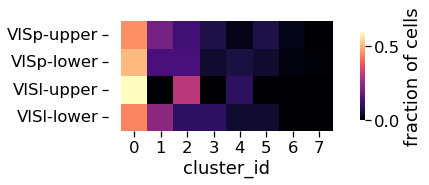

In [434]:
fig, ax = plt.subplots(figsize=(6,2.5))
ax = sns.heatmap(frequency, vmin=0, cmap='magma', ax=ax, cbar_kws={'shrink':0.8, 'label':'fraction of cells'})
ax.set_ylim((0, 4))
# ax.set_yticklabels(frequency.index, rotation=0, horizontalalignment='center')
ax.set_xlim(-0.5, len(frequency.columns)+0.5)
ax.set_ylabel('')
ax.set_title(cell_types[cre_line])
fig.tight_layout()

### normalizing to cluster size doesnt make sense

In [440]:
stats_df = cre_meta[['cluster_id', 'binned_depth']]
frequency_table= stats_df.groupby('cluster_id')['binned_depth'].value_counts(normalize=False).unstack()
frequency_table= frequency_table.fillna(0)
frequency_table

binned_depth  75    175   275  375
cluster_id                        
0             4.0  20.0  74.0  1.0
1             4.0   4.0  23.0  2.0
2             1.0   7.0  20.0  0.0
3             3.0   0.0  10.0  0.0
4             0.0   2.0  10.0  0.0
5             2.0   1.0   8.0  0.0
6             0.0   1.0   0.0  2.0
7             0.0   0.0   0.0  1.0

In [441]:
stats_df = cre_meta[['cluster_id', 'binned_depth']]
frequency_table= stats_df.groupby('cluster_id')['binned_depth'].value_counts(normalize=True).unstack()
frequency_table= frequency_table.fillna(0)
frequency_table

binned_depth       75        175       275       375
cluster_id                                          
0             0.040404  0.202020  0.747475  0.010101
1             0.121212  0.121212  0.696970  0.060606
2             0.035714  0.250000  0.714286  0.000000
3             0.230769  0.000000  0.769231  0.000000
4             0.000000  0.166667  0.833333  0.000000
5             0.181818  0.090909  0.727273  0.000000
6             0.000000  0.333333  0.000000  0.666667
7             0.000000  0.000000  0.000000  1.000000

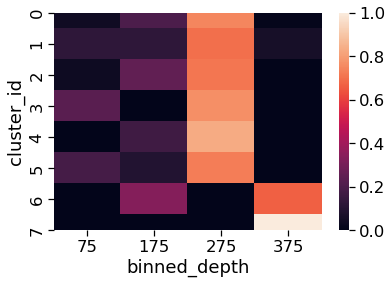

In [442]:
sns.heatmap(frequency_table)

### plots with individual cells per cluster

In [411]:
# get dropouts for some specific condition and add to cre meta for plotting
condition = ('all-images', 'Familiar')
metric_data = df[condition]
metric_data = metric_data.rename(columns={('all-images', 'Novel 1'):'metric'})
metric_data = pd.DataFrame(metric_data, columns=['metric'])
metric_meta = cre_meta.merge(metric_data, on='cell_specimen_id')

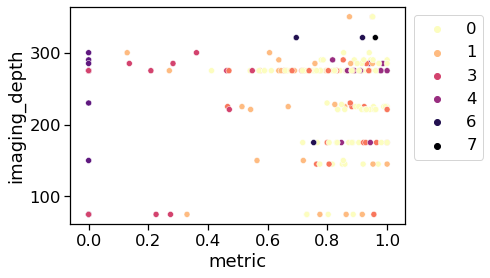

In [412]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=metric_meta, y='imaging_depth', x='metric', hue='cluster_id', palette='magma_r', ax=ax)
ax.legend(bbox_to_anchor=(1,1), )

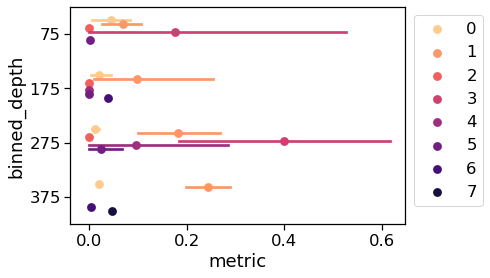

In [423]:
fig, ax = plt.subplots()
ax = sns.pointplot(data=metric_meta, y='binned_depth', x='metric', hue='cluster_id', 
                   orient='h', join=False, dodge=0.5, palette='magma_r', ax=ax)
ax.legend(bbox_to_anchor=(1,1), )

In [415]:
# get dropouts for some specific condition and add to cre meta for plotting
condition = ('behavioral', 'Novel 1')
metric_data = df[condition]
metric_data = metric_data.rename(columns={('all-images', 'Novel 1'):'metric'})
metric_data = pd.DataFrame(metric_data, columns=['metric'])
metric_meta = cre_meta.merge(metric_data, on='cell_specimen_id')

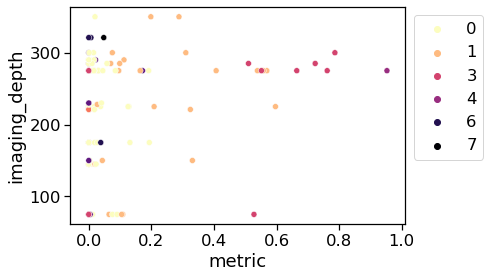

In [416]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=metric_meta, y='imaging_depth', x='metric', hue='cluster_id', palette='magma_r', ax=ax)
ax.legend(bbox_to_anchor=(1,1), )

In [363]:
cluster_meta

cell_specimen_id  cluster_id labels  ophys_experiment_id equipment_name  \
0          1086490067           0      1            842973730        CAM2P.3   
1          1086490073           5      9            940852658        CAM2P.3   
2          1086490095           5      9            842973730        CAM2P.3   
3          1086490129           3      4            842973730        CAM2P.3   
4          1086490246           8      2            842973730        CAM2P.3   
...               ...         ...    ...                  ...            ...   
3916       1086673279           5     10            848760990         MESO.1   
3917       1086673299           8      8            848760990         MESO.1   
3918       1086673376           1      0            848760990         MESO.1   
3919       1086673402           7      3            848760990         MESO.1   
3920       1086673591           7      3            848760990         MESO.1   

                                          full_genotype  mouse_id  \
0     Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...    440298   
1     Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...    459777   
2     Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...    440298   
3     Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...    440298   
4     Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...    440298   
...                                                 ...       ...   
3916      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    438912   
3917      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    438912   
3918      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    438912   
3919      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    438912   
3920      Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt    438912   

                   reporter_line                      driver_line sex  ...  \
0             Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   M  ...   
1             Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   F  ...   
2             Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   M  ...   
3             Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   M  ...   
4             Ai93(TITL-GCaMP6f)  [Slc17a7-IRES2-Cre, Camk2a-tTA]   M  ...   
...                          ...                              ...  ..  ...   
3916  Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   M  ...   
3917  Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   M  ...   
3918  Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   M  ...   
3919  Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   M  ...   
3920  Ai148(TIT2L-GC6f-ICL-tTA2)                   [Vip-IRES-Cre]   M  ...   

      area_binned_depth  layer      date  first_novel  \
0              VISp_375  lower  20190328        False   
1              VISp_175  upper  20190906        False   
2              VISp_375  lower  20190328        False   
3              VISp_375  lower  20190328        False   
4              VISp_375  lower  20190328        False   
...                 ...    ...       ...          ...   
3916            VISl_75  upper  20190409        False   
3917            VISl_75  upper  20190409        False   
3918            VISl_75  upper  20190409        False   
3919            VISl_75  upper  20190409        False   
3920            VISl_75  upper  20190409        False   

      n_relative_to_first_novel  last_familiar  last_familiar_active  \
0                          -2.0          False                  True   
1                          -1.0           True                  True   
2                          -2.0          False                  True   
3                          -2.0          False                  True   
4                          -2.0          False                  True   
...                         ...            ...                   ...   
3916                       -1.0           True                  True   
3917             

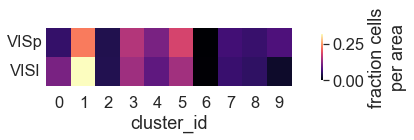

In [398]:
area_df = pd.DataFrame(frequency_table_area.unstack(), columns=['fraction']).reset_index()
area_df = area_df.groupby(['cluster_id', 'targeted_structure']).mean().unstack()
area_df.columns = area_df.columns.droplevel()
fig, ax = plt.subplots(figsize=(6,2))
ax = sns.heatmap(area_df.T, vmin=0, cmap='magma', ax=ax, cbar_kws={'shrink':0.8, 'label':'fraction cells\nper area'})
ax.set_ylim((0, 2))
ax.set_yticklabels(area_df.T.index, rotation=0, horizontalalignment='center')
ax.set_ylabel('')
ax.set_xlim(-0.5, len(area_df)+0.5)
fig.tight_layout()

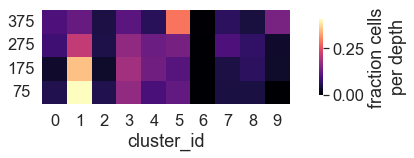

In [399]:
depth_df = pd.DataFrame(frequency_table_depth.unstack(), columns=['fraction']).reset_index()
depth_df = depth_df.groupby(['cluster_id', 'binned_depth']).mean().unstack()
depth_df.columns = depth_df.columns.droplevel()

fig, ax = plt.subplots(figsize=(6,2.5))
ax = sns.heatmap(depth_df.T, vmin=0, cmap='magma', ax=ax, cbar_kws={'shrink':0.8, 'label':'fraction cells\nper depth'})
ax.set_ylim((0, 4))
ax.set_yticklabels(depth_df.T.index, rotation=0, horizontalalignment='center')
ax.set_xlim(-0.5, len(depth_df)+0.5)
ax.set_ylabel('')
fig.tight_layout()

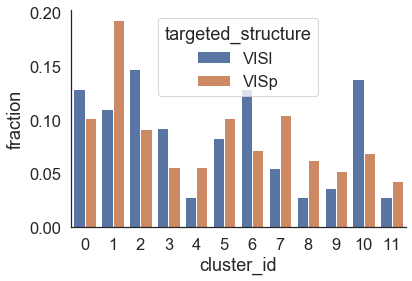

In [338]:
fig, ax = plt.subplots
sns.barplot(data=area_df, x='cluster_id', y='fraction', hue='targeted_structure')

In [253]:
frequency_table_depth

cluster_id          0         1         2         3         4         5   \
binned_depth                                                               
75            0.052083  0.302083  0.093750  0.041667  0.062500  0.156250   
175           0.141463  0.136585  0.078049  0.073171  0.034146  0.097561   
275           0.102041  0.091837  0.132653  0.071429  0.071429  0.051020   
375           0.062500  0.312500  0.375000  0.062500  0.000000  0.000000   

cluster_id          6         7         8         9         10        11  
binned_depth                                                              
75            0.031250  0.093750  0.010417  0.052083  0.083333  0.020833  
175           0.107317  0.112195  0.092683  0.039024  0.053659  0.034146  
275           0.102041  0.061224  0.020408  0.061224  0.163265  0.071429  
375           0.062500  0.000000  0.000000  0.062500  0.062500  0.000000